# Main notebook for Bayesball

Main notebook for Bayesball analysis. Needs to be cleaned up. This is ongoing and not final. Many of the cells can be rewritten as individual functions. 

In [51]:
# Libraries - needs some cleaning up
from IPython.display import HTML
import os
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pybaseball
pybaseball.cache.enable()
from pybaseball import statcast, playerid_lookup, playerid_reverse_lookup, statcast_pitcher
from pybaseball import lahman
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from IPython.core.debugger import set_trace
import concurrent.futures
import time
import pickle 
from tqdm import tqdm
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Define helper function

In [2]:
########################################################################
#                                                                      #
#                            FIGURE FUNCTIONS                          #
#                                                                      #
########################################################################

# Helper functions from tutorial on customizing violin plots. 
# https://matplotlib.org/stable/gallery/statistics/customized_violin.html

def get_color_list(cmap="plasma"):
    these_colors = []
    for row in sns.color_palette(cmap,as_cmap=False,n_colors=len(which_pitches)): #frequent_pitches.index)):
        these_colors.append([*row,1.])
    return these_colors

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    
    
def my_violinplot(local_data=[],true_shift=[],deviation=[],ax=[],which_pitches=[],bin_locs=[],widths=.1):
    
    # Create new axis if none is provided
    if ax is None:
        ax = plt.gca()
        
    # Convert data into numpy array with different column sizes (http://www.asifr.com/transform-grouped-dataframe-to-numpy.html)
    xt  = local_data[local_data.pitch_name.isin(which_pitches)].loc[:,[deviation]].values
    g   = local_data[local_data.pitch_name.isin(which_pitches)].reset_index(drop=True).groupby(true_shift + "_qbinned")
    xtg = [xt[i.values,:] for k,i in g.groups.items()]
    xout = np.array(xtg,dtype=object)

    # Make violin plot
    parts = plt.violinplot(xout,positions=bin_locs, showmeans=False, showmedians=False,
            showextrema=False,widths=widths)

    # Customize - mostly copied from https://matplotlib.org/stable/gallery/statistics/customized_violin.html
    for pc in parts['bodies']:
        pc.set_facecolor('lightgrey')
        pc.set_edgecolor('darkgrey')
        pc.set_alpha(1)
        pc.set_zorder(2)

        # pc.set_facecolor((0.7,0.7,0.7))
        # pc.set_edgecolor('black')
        # pc.set_alpha(1)
    
    
    # Customize violins
    quartile1, medians, quartile3 = [], [], []
    for arr in xout:
        q1, med, q3 = np.percentile(arr, [25, 50, 75])
        quartile1.append(q1)
        medians.append(np.mean(arr))
        quartile3.append(q3)
    whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(xout, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    iqr_color=(0.5,0.5,0.5)#"grey"
    s1   = ax.scatter(bin_locs, medians, marker='o', color='white', s=15, zorder=3)
    ln1  = ax.vlines(bin_locs, quartile1, quartile3, color=iqr_color, linestyle='-', lw=5)
    s2   = ax.scatter(bin_locs, quartile3, marker='o', color=iqr_color, s=12, zorder=3)
    s3   = ax.scatter(bin_locs, quartile1, marker='o', color=iqr_color, s=12, zorder=3)
    ln2  = ax.vlines(bin_locs, whiskers_min, whiskers_max, color=iqr_color, linestyle='-', lw=1)
        
    return ax, parts

def run_regression(xx,yy):
    X = sm.add_constant(xx)#, prepend=False)
    ols = sm.OLS(yy,X)
    ols_result = ols.fit()
    return ols_result


# Process data for analysis

In [3]:
# Either load data or gather using pybaseball
load_data = True # False #

In [4]:
# Define baseball radius and optimal launch angle
baseball_radius = 2.9/2
optimal_launch_angle = 25

# Dates for gathering data
start_date = '2015-04-01'
end_date   = '2021-11-01'

# Get data
if not load_data:
    # Get data using pybaseball
    data = statcast(start_dt=start_date,end_dt=end_date)
    first_total = len(data.index)
    print("Total number of pitches in raw data: ", first_total)
    
    # Sort by date and reset the index
    temp = data.sort_values(by="game_date")
    data = temp.reset_index()

    # Remove rows from exhibition and spring training
    data = data[~data['game_type'].isin(['E','S'])]

    # Dump file for faster access later
    data.to_pickle("data/statcast_data_2015-2021_raw.pkl")

In [40]:
# Read raw data
data = pd.read_pickle("data/statcast_data_2015-2021_raw.pkl")
total_pitches_raw = len(data.index)

# Add year as column
data['year']=pd.DatetimeIndex(data['game_date']).year

# Change knucklecurve to curve since its the same pitch for this analysis
data["pitch_name"].replace({"Knuckle Curve": "Curveball"},inplace=True)

# Remove rows with nan 
# data = data.dropna(subset=['release_pos_x'])
data['release_pos_x'] = data['release_pos_x'].astype(float)

# Remove rows with nan 
# data = data.dropna(subset=['release_pos_z'])
data['release_pos_z'] = data['release_pos_z'].astype(float)

data.loc[:,"pfx_z"] = data.loc[:,"pfx_z"].astype("float")
data.loc[:,"pfx_x"] = data.loc[:,"pfx_x"].astype("float")
data.dropna(subset=['release_pos_x','release_pos_z','pfx_x','pfx_z'],inplace=True)
data.loc[:,"pfx_z_inches"] = data.loc[:,"pfx_z"].astype("float")*12
data.loc[:,"pfx_z_norm"] = np.array((data.loc[:,'pfx_z'])/(data.loc[:,'sz_top'] - data.loc[:,'sz_bot']),dtype="float")

# Convert plate_x to % of strike zone
plate_x_left, plate_x_right = -0.71, 0.71
data.dropna(subset=['plate_x'],inplace=True)
data.loc[:,'plate_x_norm'] = np.array((.25-(-.25))*((data.loc[:,'plate_x']-plate_x_left)/ (plate_x_right - plate_x_left))+(-.25),dtype="float")
# data.loc[:,'plate_x_norm'] = np.array((data.loc[:,'plate_x']-plate_x_left)/ (plate_x_right - plate_x_left),dtype="float")

#########################################################################
#                                                                       #
#                      Calculate and bin plate_z                        #
#                                                                       #
#########################################################################
# Clean up plate z - make vals < 0 --> nan and remove
data.loc[:,'plate_z'] = data.loc[:,'plate_z'].mask(data.loc[:,'plate_z']<0)
data.dropna(subset=['plate_z'],inplace=True)

# Convert plate_z crossing to % of strikezone
data.loc[:,'plate_z_norm'] = np.array((data.loc[:,'plate_z']-data.loc[:,'sz_bot']) / (data.loc[:,'sz_top'] - data.loc[:,'sz_bot']),dtype="float")

# Bin plate z percent data - clean up first to remove outliers
data = data[(data.loc[:,"plate_z_norm"] >= np.percentile(data.loc[:,"plate_z_norm"],0.1)) & (data.loc[:,"plate_z_norm"] <= np.percentile(data.loc[:,"plate_z_norm"],99.9))]
data.dropna(subset=['plate_z_norm'],inplace=True)

# Define bin labels and bin by # of percetiles
bin_labels = list(map(str, range(1,10))) #['1','2','3','4','5','6','7','8','9']
plate_z_norm_qbinned , plate_z_norm_qbins = pd.qcut(data['plate_z_norm'].astype("float"),q=len(bin_labels), labels=bin_labels,retbins=True)
data['plate_z_norm_qbinned'] = plate_z_norm_qbinned

# Compute mean of bin from bin edges
plate_z_norm_qbins_mean = []
for idx in range(len(plate_z_norm_qbins)-1):
    plate_z_norm_qbins_mean.append(round(np.mean( [ plate_z_norm_qbins[idx] , plate_z_norm_qbins[idx+1] ] ),3))
    
plate_z_norm_qbinned_percentile      = []
plate_z_norm_qbinned_percentile_mean = []
for val in data['plate_z_norm_qbinned']:
    plate_z_norm_qbinned_percentile_mean.append(plate_z_norm_qbins_mean[int(val)-1])
    plate_z_norm_qbinned_percentile.append(plate_z_norm_qbins[int(val)-1])

data.loc[:,'plate_z_norm_qbinned_percentile']      = np.array(plate_z_norm_qbinned_percentile,dtype="float")
data.loc[:,'plate_z_norm_qbinned_percentile_mean'] = np.array(plate_z_norm_qbinned_percentile_mean,dtype="float")

#########################################################################
#                                                                       #
#                      Calculate contact error                          #
#                                                                       #
#########################################################################

data['launch_angle'] = data['launch_angle'].astype(float)
data.dropna(subset=["launch_angle"],inplace=True)

# Calculate contact error
data.loc[:,'vertical_contact_error'] = np.array(-baseball_radius*(np.sin (-optimal_launch_angle* np.pi / 180) - np.sin(-data.loc[:,'launch_angle']* np.pi / 180)),dtype="float")
data.dropna(subset=["vertical_contact_error"],inplace=True)

# Convert contact error to % of strikezone
data.loc[:,'vertical_contact_error_norm'] = np.array(data.loc[:,'vertical_contact_error']  / (12*(data.loc[:,'sz_top'] - data.loc[:,'sz_bot'])),dtype="float") #  (baseball_radius*2)
data.dropna(subset=["vertical_contact_error_norm"],inplace=True)


# ## NEEDS CLEANING UP

# #########################################################################
# #                                                                       #
# #    Process raw data (keep data with launch angle, i.e. contact)       #
# #                                                                       #
# #########################################################################

# # Load raw data
# data = pd.read_pickle("data/statcast_data_2015-2021_raw.pkl")

# # Add year as column
# data['year']=pd.DatetimeIndex(data['game_date']).year

# # Remove rows with no launch angle 
# data = data.dropna(subset=['launch_angle'])
# data['launch_angle'] = data['launch_angle'].astype(float)

# # Change knucklecurve to curve since its the same pitch for this analysis
# data["pitch_name"].replace({"Knuckle Curve": "Curveball"},inplace=True)

# # Remove rows with nan 
# data = data.dropna(subset=['release_pos_x'])
# data['release_pos_x'] = data['release_pos_x'].astype(float)

# # Remove rows with nan 
# data = data.dropna(subset=['release_pos_z'])
# data['release_pos_z'] = data['release_pos_z'].astype(float)

# #########################################################################
# #                                                                       #
# #                      Calculate and bin plate_z                        #
# #                                                                       #
# #########################################################################

# # Convert plate_x crossing to % of strikezone
# plate_x_left, plate_x_right = -0.71, 0.71
# data.dropna(subset=['plate_x'],inplace=True)
# data.loc[:,'plate_x_norm'] = np.array((.25-(-.25))*((data.loc[:,'plate_x']-plate_x_left)/ (plate_x_right - plate_x_left))+(-.25),dtype="float")
# # data.loc[:,'plate_x_norm'] = np.array((data.loc[:,'plate_x']-plate_x_left)/ (plate_x_right - plate_x_left),dtype="float")


# # Bin plate x percent data - clean up first to remove outliers
# data = data[(data.loc[:,"plate_x_norm"] >= np.percentile(data.loc[:,"plate_x_norm"],0.1)) & (data.loc[:,"plate_x_norm"] <= np.percentile(data.loc[:,"plate_x_norm"],99.9))]

# # Clean up plate z - make vals < 0 --> nan and remove
# data.loc[:,'plate_z'] = data.loc[:,'plate_z'].mask(data.loc[:,'plate_z']<0)
# data.dropna(subset=['plate_z'],inplace=True)

# # Convert plate_z crossing to % of strikezone
# data.loc[:,'plate_z_norm'] = np.array((data.loc[:,'plate_z']-data.loc[:,'sz_bot']) / (data.loc[:,'sz_top'] - data.loc[:,'sz_bot']),dtype="float")

# # a,b = 0,1
# # data.loc[:,'plate_z_norm_ab'] = np.array((b-a)*((data.loc[:,'plate_z']-data.loc[:,'sz_bot']) / (data.loc[:,'sz_top'] - data.loc[:,'sz_bot']))+a,dtype="float")

# # Bin plate z percent data - clean up first to remove outliers
# data = data[(data.loc[:,"plate_z_norm"] >= np.percentile(data.loc[:,"plate_z_norm"],0.1)) & (data.loc[:,"plate_z_norm"] <= np.percentile(data.loc[:,"plate_z_norm"],99.9))]

# # Define bin labels and bin by # of percetiles
# bin_labels = list(map(str, range(1,10))) #['1','2','3','4','5','6','7','8','9']
# data.dropna(subset=['plate_z_norm'],inplace=True)
# plate_z_norm_qbinned , plate_z_norm_qbins = pd.qcut(data['plate_z_norm'].astype("float"),q=len(bin_labels), labels=bin_labels,retbins=True)
# data['plate_z_norm_qbinned'] = plate_z_norm_qbinned

# # Compute mean of bin from bin edges
# plate_z_norm_qbins_mean = []
# for idx in range(len(plate_z_norm_qbins)-1):
#     plate_z_norm_qbins_mean.append(round(np.mean( [ plate_z_norm_qbins[idx] , plate_z_norm_qbins[idx+1] ] ),3))
    
# plate_z_norm_qbinned_percentile      = []
# plate_z_norm_qbinned_percentile_mean = []
# for val in data['plate_z_norm_qbinned']:
#     plate_z_norm_qbinned_percentile_mean.append(plate_z_norm_qbins_mean[int(val)-1])
#     plate_z_norm_qbinned_percentile.append(plate_z_norm_qbins[int(val)-1])

# data.loc[:,'plate_z_norm_qbinned_percentile']      = np.array(plate_z_norm_qbinned_percentile,dtype="float")
# data.loc[:,'plate_z_norm_qbinned_percentile_mean'] = np.array(plate_z_norm_qbinned_percentile_mean,dtype="float")

# #########################################################################
# #                                                                       #
# #                      Calculate contact error                          #
# #                                                                       #
# #########################################################################
# # Calculate contact error
# data.loc[:,'vertical_contact_error'] = np.array(-baseball_radius*(np.sin (-optimal_launch_angle* np.pi / 180) - np.sin(-data.loc[:,'launch_angle']* np.pi / 180)),dtype="float")
# data.dropna(subset=["vertical_contact_error"],inplace=True)

# # Convert contact error to % of strikezone
# data.loc[:,'vertical_contact_error_norm'] = np.array(data.loc[:,'vertical_contact_error']  / (12*(data.loc[:,'sz_top'] - data.loc[:,'sz_bot'])),dtype="float") #  (baseball_radius*2)
# data.dropna(subset=["vertical_contact_error_norm"],inplace=True)



# # Calculate contact position based on height of ball and launch angle (normalized to strike zone)
# data.loc[:,"z_contact"] = np.array((data.loc[:,'plate_z']+ (data.loc[:,'vertical_contact_error']/12) - data.loc[:,'sz_bot'])/(data.loc[:,'sz_top'] - data.loc[:,'sz_bot']),dtype="float")
# data.dropna(subset=["z_contact"],inplace=True)

# #########################################################################
# #                                                                       #
# #      Calculate and bin target and contact point (w.r.t. plate_z)      #
# #                                                                       #
# #########################################################################

# # Calculate target position based on height of ball and launch angle (normalized to strike zone)
# data.loc[:,"z_target"]  = np.array((data.loc[:,'plate_z'] -(baseball_radius*(np.sin (-optimal_launch_angle* np.pi / 180))/12) - data.loc[:,'sz_bot'])/(data.loc[:,'sz_top'] - data.loc[:,'sz_bot']),dtype="float")
# data.dropna(subset=["z_target"],inplace=True)

# # Clean up first to remove outliers
# data = data[(data.loc[:,"z_target"] >= np.percentile(data.loc[:,"z_target"],0.1)) & (data.loc[:,"z_target"] <= np.percentile(data.loc[:,"z_target"],99.9))]

# # Bin z_contact data 
# z_target_qbinned , z_target_qbins = pd.qcut(data['z_target'].astype("float"),q=len(bin_labels), labels=bin_labels,retbins=True)
# data['z_target_qbinned'] = z_target_qbinned

# # Compute mean of bin from bin edges
# z_target_qbins_mean = []
# for idx in range(len(z_target_qbins)-1):
#     z_target_qbins_mean.append(round(np.mean( [ z_target_qbins[idx] , z_target_qbins[idx+1] ] ),3))
    
# z_target_qbinned_percentile      = []
# z_target_qbinned_percentile_mean = []
# for val in data['z_target_qbinned']:
#     z_target_qbinned_percentile_mean.append(z_target_qbins_mean[int(val)-1])
#     z_target_qbinned_percentile.append(z_target_qbins[int(val)-1])

# data.loc[:,'z_target_qbinned_percentile'] = np.array(z_target_qbinned_percentile,dtype="float")
# data.loc[:,'z_target_qbinned_percentile_mean'] = np.array(z_target_qbinned_percentile_mean,dtype="float")

# #########################################################################
# #                                                                       #
# #              Calculate and bin pfx_z (w.r.t. plate_z)                 #
# #                                                                       #
# #########################################################################
# data.loc[:,"pfx_z"] = data.loc[:,"pfx_z"].astype("float")
# data.loc[:,"pfx_x"] = data.loc[:,"pfx_x"].astype("float")
# data.loc[:,"pfx_z_inches"] = data.loc[:,"pfx_z"].astype("float")*12
# data.loc[:,"pfx_z_norm"] = np.array((data.loc[:,'pfx_z'])/(data.loc[:,'sz_top'] - data.loc[:,'sz_bot']),dtype="float")
# data.dropna(subset=["pfx_z_norm"],inplace=True)

# # Bin z_contact data - clean up first to remove outliers
# data = data[(data.loc[:,"pfx_z_norm"] >= np.percentile(data.loc[:,"pfx_z_norm"],0.1)) & (data.loc[:,"pfx_z_norm"] <= np.percentile(data.loc[:,"pfx_z_norm"],99.9))]

# pfx_z_norm_qbinned , pfx_z_norm_qbins = pd.qcut(data['pfx_z_norm'].astype("float"),q=len(bin_labels), labels=bin_labels,retbins=True)
# data['pfx_z_norm_qbinned'] = pfx_z_norm_qbinned

# # Compute mean of bin from bin edges
# pfx_z_norm_qbins_mean = []
# for idx in range(len(pfx_z_norm_qbins)-1):
#     pfx_z_norm_qbins_mean.append(round(np.mean( [ pfx_z_norm_qbins[idx] , pfx_z_norm_qbins[idx+1] ] ),3))
    
# pfx_z_norm_qbinned_percentile      = []
# pfx_z_norm_qbinned_percentile_mean= []
# for val in data['pfx_z_norm_qbinned']:
#     pfx_z_norm_qbinned_percentile_mean.append(pfx_z_norm_qbins_mean[int(val)-1])
#     pfx_z_norm_qbinned_percentile.append(pfx_z_norm_qbins[int(val)-1])

# data.loc[:,'pfx_z_norm_qbinned_percentile'] = np.array(pfx_z_norm_qbinned_percentile,dtype="float")
# data.loc[:,'pfx_z_norm_qbinned_percentile_mean'] = np.array(pfx_z_norm_qbinned_percentile_mean,dtype="float")

# #########################################################################
# #                                                                       #
# #              Calculate and bin pfx_z (w.r.t. plate_z)                 #
# #                                                                       #
# #########################################################################
# # data.loc[:,"pfx_t_inches"] = data.loc[:,"pfx_z"].astype("float")*12
# data.loc[:,"pfx_t_norm"] = np.array((np.sqrt(data.loc[:,'pfx_x']**2 + data.loc[:,'pfx_z']**2))/(data.loc[:,'sz_top'] - data.loc[:,'sz_bot']),dtype="float")
# data.dropna(subset=["pfx_t_norm"],inplace=True)

# # Bin z_contact data - clean up first to remove outliers
# data = data[(data.loc[:,"pfx_t_norm"] >= np.percentile(data.loc[:,"pfx_t_norm"],0.1)) & (data.loc[:,"pfx_t_norm"] <= np.percentile(data.loc[:,"pfx_z_norm"],99.9))]

# pfx_t_norm_qbinned , pfx_t_norm_qbins = pd.qcut(data['pfx_t_norm'].astype("float"),q=len(bin_labels), labels=bin_labels,retbins=True)
# data['pfx_t_norm_qbinned'] = pfx_t_norm_qbinned

# # Compute mean of bin from bin edges
# pfx_t_norm_qbins_mean = []
# for idx in range(len(pfx_t_norm_qbins)-1):
#     pfx_t_norm_qbins_mean.append(round(np.mean( [ pfx_t_norm_qbins[idx] , pfx_t_norm_qbins[idx+1] ] ),3))
    
# pfx_t_norm_qbinned_percentile      = []
# pfx_t_norm_qbinned_percentile_mean= []
# for val in data['pfx_t_norm_qbinned']:
#     pfx_t_norm_qbinned_percentile_mean.append(pfx_t_norm_qbins_mean[int(val)-1])
#     pfx_t_norm_qbinned_percentile.append(pfx_t_norm_qbins[int(val)-1])

# data.loc[:,'pfx_t_norm_qbinned_percentile'] = np.array(pfx_t_norm_qbinned_percentile,dtype="float")
# data.loc[:,'pfx_t_norm_qbinned_percentile_mean'] = np.array(pfx_t_norm_qbinned_percentile_mean,dtype="float")


# # Save processed data
# data.to_pickle("data/statcast_data_2015-2021_cleaned.pkl")


In [36]:
###########################################
#                                         #
#      Which data to use for analysis     #
#                                         #
###########################################
which_data_true_shift = "plate_z_norm"
exec("%s = %s" % ("which_bins",which_data_true_shift + "_qbins") )
exec("%s = %s" % ("which_bins_mean",which_data_true_shift + "_qbins_mean") )
which_data_deviation ="vertical_contact_error_norm"
print(which_bins_mean)

[-0.575, -0.115, 0.084, 0.239, 0.38, 0.521, 0.677, 0.881, 1.601]


# Process pitching

In [46]:
#########################################################################
#                                                                       #
#                          Process Pitching                             #
#                                                                       #
#########################################################################

# Create dictionary for matching pitch names with codes

pitch_type_codes = {"Sinker"         : "SI",
                    "Changeup"       : "CH",
                    "Slider"         : "SL",
                    "4-Seam Fastball": "FF",
                    "Knuckle Curve"  : "KC",
                    "Curveball"      : "CU",
                    "2-Seam Fastball": "FT",
                    "Cutter"         : "FC",
                    "Split-Finger"   : "FS",
                    "Splitter"       : "FS",
                    "Pitch Out"      : "PO",
                    "Eephus"         : "EP",
                    "Forkball"       : "FO",
                    "Knuckleball"    : "KN",
                    "Fastball"       : "FA",
                    "Screwball"      : "SC",
                    "nan"            : "UN",
                    " "              : " "
                   }

# Get all pitches
all_pitches  = data.pitch_name.value_counts()
frequent_pitches = all_pitches[all_pitches > 10000]
which_pitches = frequent_pitches.index
    
# Pre-allocate variables    
const   = []
means   = []
se_mean = []
se_lo   = []
se_hi   = []
err_at_middle = []
pitch_codes = []

# Run regression 
for pitch in which_pitches:
    # Get pitch and associated data
    temp = data[data["pitch_name"].isin([pitch])]
    ols_result = run_regression(temp[which_data_true_shift + "_qbinned_percentile"],temp[which_data_deviation])

    
    # Append results to lists
    pitch_codes.append( list(pitch_type_codes.values())[list(pitch_type_codes.keys()).index(pitch)] )    
    const.append(ols_result.params[0])
    means.append(ols_result.params[1])
    se_mean.append([ols_result.bse[0],ols_result.bse[1]])
    se_lo.append(ols_result.params[1] - ols_result.bse[0])
    se_hi.append(ols_result.params[1] + ols_result.bse[1])
    err_at_middle.append(ols_result.params[0] + ols_result.params[1] * (0))
    
    
# Compute regression using statmodels.OLS for ALL PITCHES in which_pitches
temp = data[data.pitch_name.isin(which_pitches)]
xx_all = np.array(temp[which_data_true_shift + "_qbinned_percentile_mean"])#_qbinned_percent_mean
yy_all = np.array(temp[which_data_deviation])
ols_result_all = run_regression(xx_all,yy_all)
prstd_ols_all, iv_l_ols_all, iv_u_ols_all = wls_prediction_std(ols_result_all) # for getting confidence intervals

# X_all = sm.add_constant(xx_all)#, prepend=False)
# ols_all = sm.OLS(yy_all,X_all)
# ols_result_all = ols_all.fit()

# Append results of all pitches to list
pitch_codes.append("All")    
const.append(ols_result_all.params[0])
means.append(ols_result_all.params[1])
se_mean.append([ols_result_all.bse[0],ols_result_all.bse[1]])
se_lo.append(ols_result_all.params[1] - ols_result_all.bse[0])
se_hi.append(ols_result_all.params[1] + ols_result_all.bse[1])
err_at_middle.append(ols_result_all.params[0] + ols_result_all.params[1] * (0.5))

# Add to dataframe for easy manipulation and plotting
pitch_list = which_pitches.values.tolist()
pitch_list.append('All')
results_by_pitch = pd.DataFrame({'pitch': pitch_list,
                                 'pitch_code': pitch_codes,
                                 'const': const,
                                 'means': means,
                                 'absmeans': [-1*ii for ii in means],
                                 'se_mean': se_mean,
                                 'se_mean_lo': se_lo,
                                 'se_mean_hi': se_hi,
                                 'error_at_mid': err_at_middle})

In [42]:
# ########################################################################
# #                                                                      #
# #                            FIGURE FUNCTIONS                          #
# #                                                                      #
# ########################################################################

# # Helper functions from tutorial on customizing violin plots. 
# # https://matplotlib.org/stable/gallery/statistics/customized_violin.html

# def adjacent_values(vals, q1, q3):
#     upper_adjacent_value = q3 + (q3 - q1) * 1.5
#     upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

#     lower_adjacent_value = q1 - (q3 - q1) * 1.5
#     lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
#     return lower_adjacent_value, upper_adjacent_value


# def set_axis_style(ax, labels):
#     ax.xaxis.set_tick_params(direction='out')
#     ax.xaxis.set_ticks_position('bottom')
#     ax.set_xticks(np.arange(1, len(labels) + 1))
#     ax.set_xticklabels(labels)
#     ax.set_xlim(0.25, len(labels) + 0.75)
    
    
# def my_violinplot(local_data=[],true_shift=[],deviation=[],ax=[],which_pitches=[],bin_locs=[]):
    
#     # Create new axis if none is provided
#     if ax is None:
#         ax = plt.gca()
        
#     # Convert data into numpy array with different column sizes (http://www.asifr.com/transform-grouped-dataframe-to-numpy.html)
#     xt  = local_data[local_data.pitch_name.isin(which_pitches)].loc[:,[deviation]].values
#     g   = local_data[local_data.pitch_name.isin(which_pitches)].reset_index(drop=True).groupby(true_shift + "_qbinned")
#     xtg = [xt[i.values,:] for k,i in g.groups.items()]
#     xout = np.array(xtg,dtype=object)

#     # Make violin plot
#     parts = plt.violinplot(xout,positions=bin_locs, showmeans=False, showmedians=False,
#             showextrema=False,widths=.1)

#     # Customize - mostly copied from https://matplotlib.org/stable/gallery/statistics/customized_violin.html
#     for pc in parts['bodies']:
#         pc.set_facecolor('lightgrey')
#         pc.set_edgecolor('darkgrey')
#         pc.set_alpha(1)
#         pc.set_zorder(2)

#         # pc.set_facecolor((0.7,0.7,0.7))
#         # pc.set_edgecolor('black')
#         # pc.set_alpha(1)
    
    
#     # Customize violins
#     quartile1, medians, quartile3 = [], [], []
#     for arr in xout:
#         q1, med, q3 = np.percentile(arr, [25, 50, 75])
#         quartile1.append(q1)
#         medians.append(np.mean(arr))
#         quartile3.append(q3)
#     whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(xout, quartile1, quartile3)])
#     whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

#     inds = which_bins_mean
#     iqr_color=(0.5,0.5,0.5)#"grey"
#     s1   = ax.scatter(inds, medians, marker='o', color='white', s=15, zorder=3)
#     ln1  = ax.vlines(inds, quartile1, quartile3, color=iqr_color, linestyle='-', lw=5)
#     s2   = ax.scatter(inds, quartile3, marker='o', color=iqr_color, s=12, zorder=3)
#     s3   = ax.scatter(inds, quartile1, marker='o', color=iqr_color, s=12, zorder=3)
#     ln2  = ax.vlines(inds, whiskers_min, whiskers_max, color=iqr_color, linestyle='-', lw=1)
        
#     return ax, parts


# Figure 1 OLD
This figure is no longer in use. This is the original Figure 1, which has since been removed and replaced. Keeping it here for reference and to show how its made mostly in python

/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels

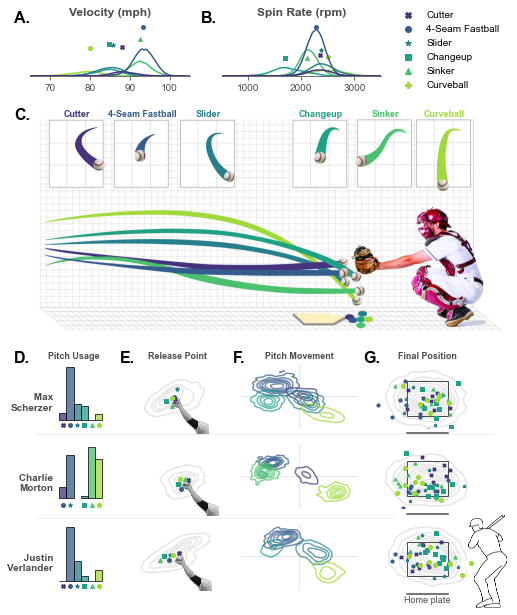

In [43]:
########################################################################
#                                                                      #
#                  MAKE FIGURE SHOWING RELEASE/ETC                     #
#                                                                      #
########################################################################

# This is the original Figure 1, which has since been removed and replaced. 
# Keeping it here for reference and to show how its built almost entirely in python

def get_color_list(cmap="viridis"):
    these_colors = []
    for row in sns.color_palette(cmap,as_cmap=False,n_colors=len(which_pitches)): #frequent_pitches.index)):
        these_colors.append([*row,1.])
    return these_colors
    
def make_cmap(clr="Reds"):
    return cm.get_cmap(plt.get_cmap(clr))(np.linspace(0.0, 1.0, 100))[np.newaxis, :, :3]
  
def make_color_order(graded=True,cmap="viridis"):
    # Graded means a color map is applied to for each color so that KDE plots have a gradient. Otherwise it is a fixed color
    markers = ["X","^","*","s","o","P","D","v"]
    order = pd.DataFrame({"pitch": [], "colormap": [], "color": [], "marker": []})
    if graded:
        cmaps = ["Greys", "Blues", "Reds", "Greens", "Purples", "Oranges", "RdPu"]
        for cnt,(pitch, clr, mrkr) in enumerate(zip(which_pitches,cmaps,markers[:len(which_pitches)])):   
            local_cmap = make_cmap(clr=clr)
            order = pd.concat([order,pd.DataFrame({"pitch": pitch, "colormap": clr, "color": [local_cmap[0][50]],"marker": mrkr})],ignore_index=True, axis=0)
    else:
        cmaps = len(markers)*[cmap]
        for cnt,(pitch, clr, mrkr,this_clr) in enumerate(zip(which_pitches,cmaps,markers[:len(which_pitches)],get_color_list(cmap=cmap))):   
            order = pd.concat([order,pd.DataFrame({"pitch": pitch, "colormap": clr, "color": [this_clr],"marker": mrkr})],ignore_index=True, axis=0)

    return order

light_gray = tuple(3*[225/255])
dark_grey = tuple(3*[0.3])

# Define pitch colors, markers, etc
pitches = ["Cutter","4-Seam Fastball","Slider", "Changeup","Sinker","Curveball",]    
markers = ["X","o","*","s","^","P"]#["o","o"ax_top_L.spines['bottom'].set_color(tuple(3*[0.2])),"o","o","o","o"]#,"D"]#,"v"]    
colors  = sns.color_palette("viridis",as_cmap=False,n_colors=len(pitches))#[(32/255,242/255,182/255), (31/255,123/255,254/255), (249/255,15/255,18/255), (254/255,126/255,0/255), (93/255,247/255,2/255), (185/255,1/255,7/255)]#
order = pd.DataFrame({"pitch": [], "colormap": [], "color": [], "marker": []})
for (pitch, clr, mrkr,this_clr) in zip(pitches,colors,markers,colors):   
    order = pd.concat([order,pd.DataFrame({"pitch": pitch, "colormap": [clr], "color": [this_clr],"marker": mrkr})],ignore_index=True, axis=0)

# order = make_color_order(graded=False,cmap="viridis")
order.reset_index(inplace=True)

# Which pitchers to show                               
pitchers = ["Scherzer, Max", "Morton, Charlie", "Verlander, Justin"]

###########################################
#                                         #
#   Define figure layout using gridspec   #
#                                         #
###########################################
fig = plt.figure(constrained_layout=False)
fig.set_size_inches(7.5,8)

# Top panel
gs_top = fig.add_gridspec(nrows=1, ncols=2, left=0.1, right=0.75,bottom=0.9,top=.99)#,width_ratios=[1,1,1])
ax_top_L = fig.add_subplot(gs_top[0,0],facecolor="None",)
ax_top_C = fig.add_subplot(gs_top[0,1],facecolor="None")
# ax_top_R = fig.add_subplot(gs_top[0,2],facecolor="None")

# Middle panel
img_ratio = 1440/684
xx,yy = 0.01,0.95
height = (yy-xx)*img_ratio
gs_mid = fig.add_gridspec(nrows=1, ncols=1, left=0.1, right=0.99,bottom=0.455,top=.825)
ax_mid = fig.add_subplot(gs_mid[0,0],facecolor="None",visible=True)#False)

# Bottom panel
nrows, ncols = len(pitchers), 4
gs_bot = fig.add_gridspec(nrows=nrows, ncols=ncols, left=0.15, right=0.99,top=.4,bottom=0.01,wspace=0.1,hspace=0.25,width_ratios=[0.5,1,1.2,1.75])
# ax_bot=[]
ax=[]
for col in range(ncols):
    for row in range(nrows):
        # ax_bot.append(fig.add_subplot(gs_bot[col,row]))
        ax.append(fig.add_subplot(gs_bot[row,col],facecolor="None"))
        
#############################
#                           #            
#    Make top left panel    #
#                           #
#############################
plt.sca(ax_top_L)
data.loc[:,"release_speed"] = data.loc[:,"release_speed"].astype("float")
sns.kdeplot(ax=ax_top_L,data=data[data.pitch_name.isin(pitches)],x="release_speed",hue="pitch_name",fill=False,hue_order=order.pitch.tolist(),legend=False,palette=order.color.tolist())#,kde=True)
ax_top_L.set_xlim([65,105])
ax_top_L.yaxis.set_visible(False)
ax_top_L.spines['right'].set_color('none')
ax_top_L.spines['left'].set_color('none')
ax_top_L.spines['top'].set_color('none')
ax_top_L.set_title("Velocity (mph)",y=1.05,color=dark_grey,fontweight="bold")
ax_top_L.xaxis.label.set_visible(False)
ax_top_L.spines['bottom'].set_color(dark_grey)
ax_top_L.xaxis.label.set_color(dark_grey)
ax_top_L.tick_params(axis='x', colors=dark_grey)

for (line,clr,mrkr) in zip(ax_top_L.lines,colors[::-1],markers[::-1]):
    plt.scatter(x=line._x[line._y.argmax()],y=line._y[line._y.argmax()]+0.05+0.0025*np.random.randn(1),marker=mrkr,color=clr,s=15)#+0.01*np.random.randn(1)

#############################
#                           #            
#   Make top center panel   #
#                           #
#############################    
plt.sca(ax_top_C)
data.loc[:,"release_spin_rate"] = data.loc[:,"release_spin_rate"].astype("float")
ax_top_C = sns.kdeplot(ax=ax_top_C,data=data[data.pitch_name.isin(pitches)],x="release_spin_rate",hue="pitch_name",fill=False,hue_order=order.pitch.tolist(),palette=order.color.tolist())#,kde=True)
ax_top_C.set_xlim([500,3500])
ax_top_C.set_xticks([1000,2000,3000])
ax_top_C.yaxis.set_visible(False)
ax_top_C.spines['right'].set_color('none')
ax_top_C.spines['left'].set_color('none')
ax_top_C.spines['top'].set_color('none')
ax_top_C.set_title("Spin Rate (rpm)",y=1.05,color=dark_grey,fontweight="bold")
ax_top_C.xaxis.label.set_visible(False)
ax_top_C.spines['bottom'].set_color(dark_grey)
ax_top_C.xaxis.label.set_color(dark_grey)
ax_top_C.tick_params(axis='x', colors=dark_grey)

for (line,clr,mrkr) in zip(ax_top_C.lines,colors[::-1],markers[::-1]):
    plt.scatter(x=line._x[line._y.argmax()],y=line._y[line._y.argmax()]+0.0002+0.0001*np.random.randn(1),marker=mrkr,color=clr,s=15)#+0.01*np.random.randn(1)
    
for row in order.itertuples():
    ax_top_C.scatter([], [], color=row.color, marker=row.marker, alpha=1, label=row.pitch)
ax_top_C.legend(loc="center left",bbox_to_anchor=(1.05, 0.50),frameon=False)    
ax_in = []


########################################################
#                                                      #            
#   Get data for each pitcher, plot in bottom panels   #
#                                                      #
########################################################
for count, pitcher in enumerate(pitchers):
    
    # Define data for first column
    _local = data[data.player_name.isin([pitcher])]
    
    
    for cnt, val in enumerate(["release_pos_x","release_pos_z","pfx_x","pfx_z"]): 
        _local.loc[:,val + "_zscore"] =  np.array((_local.loc[:,val] - _local.loc[:,val].mean()) / _local.loc[:,val].std(),dtype="float")
        # _local.loc[:,val + "_zscore"].astype("float")
        
    # _local[["release_pos_x","release_pos_z","pfx_z"]] = _local[["release_pos_x","release_pos_z"]].apply(zscore)
    _grouped = _local.groupby("pitch_name")
    
    plt.sca(ax[count])
    
    # sns.countplot(data=_local,x="pitch_name",hue_order=order.pitch.tolist(),palette=order.color.tolist(),**kwargs={"width":1})
    countplot=sns.histplot(data=_local,x="player_name",hue="pitch_name",hue_order=order.pitch.tolist(),palette=order.color.tolist(), multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=True)#sns.countplot(data=_local,x="player_name",hue="pitch_name",hue_order=order.pitch.tolist(),palette=order.color.tolist())
    # ax[count].axis("off")
    ax[count].legend_.remove()
    ax[count].set_yticks([])
    ax[count].set_xticks([])
    ax[count].set_frame_on(False)
    ax[count].set_xlabel(None)
    splitname = pitcher.split(",")
    ax[count].set_ylabel(splitname[1] + "\n" + splitname[0],rotation=0,ha="right",x=-.075,y=0.25,fontweight="bold",color=dark_grey)

    # Add marker instead of label
    for (patch,clr,mrkr) in zip(ax[count].patches,colors[::-1],markers[::-1]):
        plt.scatter(x=patch._x0 + patch._width/2,y=-.05,marker=mrkr,color=clr,s=15)
    
    # Plot KDE and scatter on top
    plt.sca(ax[count+nrows])
    if (_local.p_throws.unique()[0] == "L"):
        _local.loc[:,"release_pos_x_zscore"] = -1*_local.loc[:,"release_pos_x_zscore"]
    sns.kdeplot(data=_local, x="release_pos_x_zscore",y="release_pos_z_zscore",levels=5,legend=False,fill=False,color=(0.9, 0.9, 0.9))
    for (name, group), clr, mrkr in zip(_grouped,order.color.tolist(),order.marker.tolist()):
        _meaned = group[["release_pos_x_zscore","release_pos_z_zscore"]].mean()
        plt.scatter(x=_meaned.release_pos_x_zscore,y=_meaned.release_pos_z_zscore,color=clr,marker=mrkr,zorder=10,s=15)
    ax[count+nrows].axis("off")
 
    # Get position 
    ax_pos = ax[count+nrows].get_position()
    ax[count+nrows].set_position([ax_pos.x0+0.0275,ax_pos.y0, ax_pos.width, ax_pos.height])

    # Get position for image
    width, height = 0.55, 0.55
    xlim, ylim = ax[count+nrows].get_xlim(), ax[count+nrows].get_ylim()
    x_start, y_start = (_local["release_pos_x_zscore"].median()-xlim[0])/(xlim[1]-xlim[0]) - .1 , (_local["release_pos_z_zscore"].median()-ylim[0])/(ylim[1]-ylim[0])-height
    
    # Add image of pitcher's arm
    axins = ax[count+nrows].inset_axes((x_start, y_start, width, height))
    img = mpimg.imread('images/pitcher_arm.png')
    axins.imshow(img)
    axins.axis("off")
    ax_in.append(axins)

    # Get movement data
    plt.sca(ax[count+2*nrows])
    if (_local.p_throws.unique()[0] == "L"):
        _local.loc[:,"pfx_x"] = -1*_local.loc[:,"pfx_x"]
    
    sns.kdeplot(data=_local[_local.pitch_name.isin(pitches)], x="pfx_x",y="pfx_z",hue="pitch_name",levels=7,fill=False,hue_order=order.pitch.tolist(),palette=order.color.tolist(),legend=False,zorder=3,alpha=0.7)
    
    # Clean up axis
    ax[count+2*nrows].spines['left'].set_position('center')
    ax[count+2*nrows].spines['bottom'].set_position('center')
    ax[count+2*nrows].spines['right'].set_color('none')
    ax[count+2*nrows].spines['top'].set_color('none')
    ax[count+2*nrows].yaxis.set_visible(False)
    ax[count+2*nrows].xaxis.set_visible(False)
    ax[count+2*nrows].spines['left'].set_color(light_gray)
    ax[count+2*nrows].spines['bottom'].set_color(light_gray)
    ax[count+2*nrows].grid(b=True, which='major', color=light_gray, linestyle='-')
    ax_pos = ax[count+2*nrows].get_position()
    ax[count+2*nrows].set_position([ax_pos.x0+0.04,ax_pos.y0, ax_pos.width, ax_pos.height])

    # Add final location in x-zone
    plt.sca(ax[count+3*nrows])
    sns.kdeplot(data=_local, x="plate_x_norm",y="plate_z_norm",level=5,legend=False,fill=False,color=(0.9, 0.9, 0.9))
    for (name, group), clr, mrkr in zip(_grouped,order.color.tolist(),order.marker.tolist()):
        n_samples = 8
        if len(group) < n_samples:
            _meaned = group[["plate_x_norm","plate_z_norm"]]
        else:
            _meaned = group[["plate_x_norm","plate_z_norm"]].sample(n_samples)
        
        plt.scatter(x=_meaned.plate_x_norm,y=_meaned.plate_z_norm,color=clr,marker=mrkr,zorder=10,s=10)
        
    # Draw srikezone
    ax[count+3*nrows].plot((-.25,.25),(-.5,-.5),'k-',linewidth=1.5,clip_on=False,color=dark_grey)
    ax[count+3*nrows].add_patch(Rectangle((-.25,0),width=.5,height=1, zorder=3,fill=False,facecolor=None,edgecolor=dark_grey,clip_on=False))    
    ax[count+3*nrows].axis("off")
    ax[count+3*nrows].set_xlim([-1,1])
    ax[count+3*nrows].set_ylim([-.35,1.5])
        
# Add batter to bottom right panel        
ax_batter = ax[count+3*nrows].inset_axes((.55,-.3,.6,1.45))
img = mpimg.imread('images/batter.png')   
ax_batter.imshow(img,zorder=1)
ax_batter.axis('off')
ax_batter.set_xlim(1100,120)
ax_batter.set_ylim(2500,90)

# Add home plate
ax[count+3*nrows].text(0,-.75,"Home plate",fontsize=9,ha="center",zorder=3,color=dark_grey)

# Put modified LMU Image in middle section
img = mpimg.imread('images/LMU-pitchmovement-text-removed-newcolors.png')   
ax_mid.imshow(img)
ax_mid.axis('off')
ax_xlims, ax_ylims = ax_mid.get_xlim(), ax_mid.get_ylim()

# Add text for each pitch type
pos_arr = [600,1600,2625,4350,5355,6260]
for (pitch, clr, mrkr, xpos) in zip(pitches,colors,markers,pos_arr):
    ax_mid.text(xpos,-75,pitch,fontweight="bold",fontsize=9,color=clr,ha="center",va="center")

# Add label for each panel. All positions are w.r.t ax_mid    
ax_mid.text(-375,-1500,"A.",fontweight="bold",fontsize=16)
ax_mid.text(2500,-1500,"B.",fontweight="bold",fontsize=16)
ax_mid.text(-375,0,"C.",fontweight="bold",fontsize=16)
ax_mid.text(-375,3750,"D.",fontweight="bold",fontsize=16)
ax_mid.text(1250,3750,"E.",fontweight="bold",fontsize=16)
ax_mid.text(3000,3750,"F.",fontweight="bold",fontsize=16)
ax_mid.text(5000,3750,"G.",fontweight="bold",fontsize=16)
ax_mid.plot((-50,7000),(4850,4850),c=light_gray,linewidth=.5,clip_on=False)
ax_mid.plot((-50,5500),(6150,6150),c=light_gray,linewidth=.5,clip_on=False)
ax_mid.set_xlim(ax_xlims)
ax_mid.set_ylim(ax_ylims)

# Set axis titles
ax[0].set_title("Pitch Usage",color=dark_grey,fontweight="bold",fontsize=9,x=0.35)
ax[3].set_title("Release Point",color=dark_grey,fontweight="bold",fontsize=9)
ax[6].set_title("Pitch Movement",color=dark_grey,fontweight="bold",fontsize=9)
ax[9].set_title("Final Position",color=dark_grey,fontweight="bold",fontsize=9)

plt.rcParams.update({'font.sans-serif':'Arial'})

# Save figure
fig.savefig(os.path.join(os.getcwd(),"figures","Figure1-pitchbehavior-viridis.png"), dpi=300, facecolor='w', edgecolor='w', bbox_inches="tight")



# Plots for Figure 1 

/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 vari

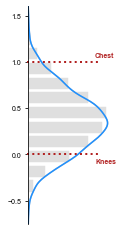

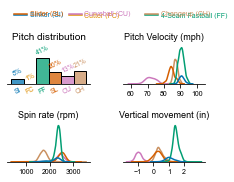

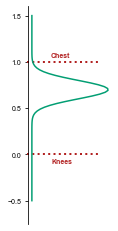

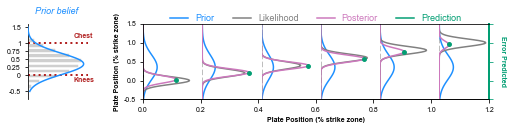

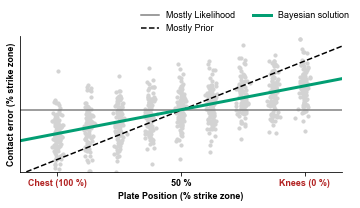

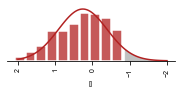

In [64]:
%run -i "figure1-v2.py"
# ########################################################################
# #                                                                      #
# #                    MAKE SUBPLOTS FOR FIGURE 1                        #
# #                                                                      #
# ########################################################################

# # The v2 figure 1 is made in inkscape, but the data figures are made here

# greinke = data[data.player_name.isin(["Greinke, Zack"])]

# # greinke["release_spin_rate"] = greinke["release_spin_rate"].fillna(0)
# greinke.loc[:,"release_speed_float"] = greinke.release_speed.astype("float64")
# greinke.loc[:,"release_spin_float"] = greinke.release_spin_rate.astype("float64")
# greinke.loc[:,"release_pos_x_float"] = greinke.release_pos_x.astype("float64")
# greinke.loc[:,"release_pos_z_float"] = greinke.release_pos_z.astype("float64")
# greinke.loc[:,"pfx_x_float"] = greinke.pfx_x.astype("float64")
# greinke.loc[:,"pfx_z_float"] = greinke.pfx_z.astype("float64")
# greinke.loc[:,"plate_x_float"] = greinke.plate_x.astype("float64")
# greinke.loc[:,"plate_z_float"] = greinke.plate_z.astype("float64")

# greinke.loc[:,"plate_x_norm"] = np.array((greinke.plate_x - (-0.71)) / (0.71 - (-0.71)),dtype="float")
# greinke.loc[:,"plate_z_norm"] = np.array((greinke.plate_z - greinke.sz_bot) / (greinke.sz_top - greinke.sz_bot), dtype="float")

# #########################################
# #                                       #
# #         Postion prior (plate_z)       #
# #                                       #
# #########################################
# fig = plt.figure(figsize=(1.5,4))
# ax = fig.add_subplot()

# # Make distribution
# sns.histplot(greinke,y="plate_z_norm",bins=15,ax=ax,color='silver',stat='density',kde=True,shrink=0.9,edgecolor="w", linewidth=1.5,zorder=2)
# sns.kdeplot(data=greinke, y="plate_z_norm",ax=ax,fill=False,color="dodgerblue",zorder=2)#color="darkgrey")
# xpos, ypos_chest, ypos_knees = 1, 1.05, -.1 #.9875, -.02

# # Add lines to label strikezone
# ax.axhline(y = 1, xmin=-.01, xmax=0.85,color='firebrick',linestyle=':',clip_on=False,zorder=2,lw=2)
# ax.axhline(y = 0, xmin=-.01, xmax=0.85,color='firebrick',linestyle=':',clip_on=False,zorder=2,lw=2)
# # ax2.axhline(y = 0, xmin=-.01, xmax=.55,color='firebrick',linestyle=':',clip_on=False,zorder=2,lw=2)
# txt1 = ax.text(xpos,ypos_chest,"Chest",color='firebrick',fontweight="bold",zorder=2)#,backgroundcolor='white')
# txt2 = ax.text(xpos,ypos_knees,"Knees",color='firebrick',fontweight="bold",zorder=2)#,backgroundcolor='white')

# # Make figure adjustments
# ax.set_xlim(0,1.25)
# ax.set_ylim(-.75,1.6)
# bin_ticks=[-.5,0,0.25,0.5,0.75,1,1.5]
# ax0.set_yticks(ticks=bin_ticks)
# ax0.set_yticklabels(list(map(str, [round(val,2) for val in bin_ticks])))#['1','2','3','4','5','6','7','8'])
# ax.tick_params(axis='y')#,direction='out')
# ax.set_ylabel(None)
# ax.xaxis.set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig("greinke_priorposition.svg")


# #########################################
# #                                       #
# #         Pitch behavior priors         #
# #                                       #
# #########################################

# # Pitches and order
# pitches = ["Sinker","Cutter","4-Seam Fastball","Slider","Curveball","Changeup"]    
# markers = ["X","o","*","s","^","P"]#["o","o"ax_top_L.spines['bottom'].set_color(tuple(3*[0.2])),"o","o","o","o"]#,"D"]#,"v"]    
# cmap =  "colorblind"#"viridis"#
# greinke_colors = []
# for row in sns.color_palette(cmap,as_cmap=False,n_colors=len(pitches)): #frequent_pitches.index)):
#     greinke_colors.append([*row,1.])    
# order = pd.DataFrame({"pitch": [], "colormap": [], "color": [], "marker": []})
# for (pitch,mrkr,this_clr) in zip(pitches,markers,greinke_colors):   
#     order = pd.concat([order,pd.DataFrame({"pitch": pitch, "color": [this_clr],"marker": mrkr, "code": pitch_type_codes[pitch]})],ignore_index=True, axis=0)

# # order = make_color_order(graded=False,cmap="viridis")
# order.reset_index(inplace=True)

# # Define figure
# fig = plt.figure(figsize=(2.75,2.15))

# # Add gridspec for legend
# gs0 = fig.add_gridspec(nrows=1, ncols=1, left=0, right=0.8, bottom=0.925,top=1)
# ax0 = fig.add_subplot(gs0[0])

# # Add grid spec for data
# gs1 = fig.add_gridspec(nrows=2, ncols=2, left=0.001, right=1, bottom=0.001,top=0.75,hspace=1.05,wspace=.4)
# ax1 = fig.add_subplot(gs1[0])
# ax2 = fig.add_subplot(gs1[1])
# ax3 = fig.add_subplot(gs1[2])
# ax4 = fig.add_subplot(gs1[3])

# # Make custom legend
# xs = np.array([0,0.25,.6,0,0.25,0.6])
# ys = np.array([0.1,0.1,0.1,0.3,0.3,0.3])
# for (row,xpos,ypos) in zip(order.itertuples(),xs,ys):
#     ax0.plot([xpos,xpos+0.06],[ypos,ypos],color=row.color)
#     ax0.text(x=xpos+0.07,y=ypos,s=row.pitch + " ({})".format(row.code),color=row.color,ha="left",va="center")
# ax0.set_frame_on(False)
# ax0.yaxis.set_visible(False)
# ax0.xaxis.set_visible(False)

# # Make barplot
# plt.sca(ax1)
# # sns.countplot(data=_local,x="pitch_name",hue_order=order.pitch.tolist(),palette=order.color.tolist(),**kwargs={"width":1})
# countplot=sns.histplot(data=greinke[greinke.pitch_name.isin(pitches)],x="player_name",hue="pitch_name",hue_order=order.pitch.tolist(),palette=order.color.tolist(), multiple="dodge", 
#               stat='density', shrink=0.8, common_norm=True)#sns.countplot(data=_local,x="player_name",hue="pitch_name",hue_order=order.pitch.tolist(),palette=order.color.tolist())

# ax1.legend_.remove()
# ax1.set_yticks([])
# ax1.set_xticks([])
# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.yaxis.set_visible(False)
# ax1.patch.set_alpha(0)
# ax1.set_xlabel(None)
# ax1.patch.set_alpha(0)
# ax1.set_title("Pitch distribution",fontsize=10)
# ax1.set(xlabel=None,ylabel=None)
# ax1.set_ylim(0,.6)

# pitch_percent = np.ceil(greinke[greinke.pitch_name.isin(pitches)].pitch_name.value_counts(normalize=True)*100)

# cnt=0
# # Add marker instead of label
# for (patch,code,percent,clr) in zip(ax1.patches[::-1],order.code.tolist(),pitch_percent[order.pitch.tolist()], order.color.tolist()):
#     # plt.scatter(x=patch._x0 + patch._width/2,y=-.05,marker=mrkr,color=clr,s=15)
#     plt.text(x=patch._x0 + patch._width/2,y=-.15,s=code,ha="center",rotation=25,color=clr)#,s=15)
#     plt.text(x=patch._x0 + patch._width/2,y=patch._height + 0.05,s="{}%".format(int(percent)),ha="center",rotation=25,fontsize=7,color=clr)#,s=15)
#     cnt+=1


# # Make velo distribution
# plt.sca(ax2)
# sns.kdeplot(data=greinke[greinke.pitch_name.isin(pitches)],x="release_speed_float",legend=False,hue="pitch_name",palette=order.color.tolist(),hue_order=order.pitch.tolist())
# ax2.set_title("Pitch Velocity (mph)",fontsize=9)
# ax2.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.spines['left'].set_visible(False)
# ax2.yaxis.set_visible(False)
# ax2.patch.set_alpha(0)
# ax2.set_xlim([55,105])
# ax2.set(xlabel=None,ylabel=None,xticks=[60,70,80,90,100])

# # Make spin distribution
# plt.sca(ax3)
# sns.kdeplot(data=greinke[greinke.pitch_name.isin(pitches)],x="release_spin_float",legend=False,hue="pitch_name",palette=order.color.tolist(),hue_order=order.pitch.tolist())
# ax3.set_title("Spin rate (rpm)",fontsize=9)
# ax3.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False)
# ax3.spines['left'].set_visible(False)
# ax3.yaxis.set_visible(False)
# ax3.patch.set_alpha(0)
# ax3.set(xlabel=None,ylabel=None)

# # Make z movement distribution
# plt.sca(ax4)
# sns.kdeplot(data=greinke[greinke.pitch_name.isin(pitches)],x="pfx_z_float",legend=False,hue="pitch_name",palette=order.color.tolist(),hue_order=order.pitch.tolist())
# ax4.set_title("Vertical movement (in)",fontsize=9)
# ax4.spines['right'].set_visible(False)
# ax4.spines['top'].set_visible(False)
# ax4.spines['left'].set_visible(False)
# ax4.yaxis.set_visible(False)
# ax4.patch.set_alpha(0)
# ax4.set(xlabel=None,ylabel=None,xticks=[-1,0,1,2])

# plt.rcParams.update({'font.size': 7})

# fig.savefig(os.path.join(os.getcwd(),"figures","Figure1-v2-BayesballStory.png"), dpi=300, facecolor='w', edgecolor='w', bbox_inches="tight")
# fig.savefig(os.path.join(os.getcwd(),"figures","Figure1-v2-BayesballStory.svg"))#, dpi=300, facecolor='w', edgecolor='w', bbox_inches="tight")


# #########################################
# #                                       #
# #         Make the likelihood           #
# #                                       #
# #########################################

# fig = plt.figure(figsize=(1.5,4))
# ax = fig.add_subplot()

# X = np.linspace(-.5, 1.5, 100)
# _L = stats.norm.pdf(X, 0.7, 0.1)
# ax.plot(_L,X,color=order[order.pitch.isin(["4-Seam Fastball"])].color.tolist()[0],zorder=3)


# # Add lines to label strikezone
# ax.axhline(y = 1, xmin=-.01, xmax=0.85,color='firebrick',linestyle=':',clip_on=False,zorder=2,lw=2)
# ax.axhline(y = 0, xmin=-.01, xmax=0.85,color='firebrick',linestyle=':',clip_on=False,zorder=2,lw=2)
# xpos, ypos_chest, ypos_knees = 1, 1.05, -.1
# txt1 = ax.text(xpos,ypos_chest,"Chest",color='firebrick',fontweight="bold",zorder=2)#,backgroundcolor='white')
# txt2 = ax.text(xpos,ypos_knees,"Knees",color='firebrick',fontweight="bold",zorder=2)#,backgroundcolor='white')

# # Make figure adjustments
# ax.set_ylim(-.75,1.6)
# bin_ticks=[-.5,0,0.25,0.5,0.75,1,1.5]
# ax0.set_yticks(ticks=bin_ticks)
# ax0.set_yticklabels(list(map(str, [round(val,2) for val in bin_ticks])))#['1','2','3','4','5','6','7','8'])
# ax.tick_params(axis='y')#,direction='out')
# ax.set_ylabel(None)
# ax.xaxis.set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig("greinke_likelihoodposition.svg")


# #########################################
# #                                       #
# #         Show the full Bayes           #
# #                                       #
# #########################################

# fig = plt.figure(figsize=(8,1.25))

# # Add gridspec for legend
# gs0 = fig.add_gridspec(nrows=1, ncols=1, left=0, right=0.1, bottom=0.01,top=.85)
# ax0 = fig.add_subplot(gs0[0])

# # Add grid spec for data
# gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.2, right=.8,bottom=0.01,top=gs0.top)# bottom=0.55,top=1)#,hspace=.25)
# ax1 = fig.add_subplot(gs1[0])
# ax1.set_ylim(-.5,1.5)
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.set_xlabel("Plate Position (% strike zone)",fontweight="bold")
# ax1.set_ylabel("Plate Position (% strike zone)",fontweight="bold")

# gs2 = fig.add_gridspec(nrows=1, ncols=1, left=gs1.left, right=gs1.right, bottom=gs1.top+0.1,top=1)#,hspace=.25)
# ax2 = fig.add_subplot(gs2[0])

# # Get pdf for greinke data
# mean,std=stats.norm.fit(greinke.plate_z_norm)
# xx = np.linspace(-.5, 1.5, 100)
# greinke_prior = stats.norm.pdf(xx, mean, std)
# sns.histplot(greinke,y="plate_z_norm",bins=15,ax=ax0,color='silver',stat='density',kde=False,shrink=0.9,edgecolor="w", linewidth=1.5,zorder=2)
# ax0.plot(greinke_prior,xx,color="dodgerblue",zorder=3)
# xpos, ypos_chest, ypos_knees = 1, 1.15, -.2 #.9875, -.02

# # Add lines to label strikezone
# ax0.axhline(y = 1, xmin=0, xmax=1.05,color='firebrick',linestyle=':',clip_on=False,zorder=2,lw=2)
# ax0.axhline(y = 0, xmin=0, xmax=1.05,color='firebrick',linestyle=':',clip_on=False,zorder=2,lw=2)
# txt1 = ax0.text(xpos,ypos_chest,"Chest",color='firebrick',fontweight="bold",zorder=2)#,backgroundcolor='white')
# txt2 = ax0.text(xpos,ypos_knees,"Knees",color='firebrick',fontweight="bold",zorder=2)#,backgroundcolor='white')

# # Make figure adjustments
# ax0.set_xlim(0,1.25)
# ax0.set_ylim(-.75,1.6)
# bin_ticks=[-.5,0,0.25,0.5,0.75,1,1.5]
# ax0.set_yticks(ticks=bin_ticks)
# ax0.set_yticklabels(list(map(str, [round(val,2) for val in bin_ticks])))#['1','2','3','4','5','6','7','8'])
# ax0.tick_params(axis='y')#,direction='out')
# ax0.set_ylabel(None)
# ax0.xaxis.set_visible(False)
# ax0.spines['bottom'].set_visible(False)
# ax0.spines['top'].set_visible(False)
# ax0.spines['right'].set_visible(False)


# #### AXIS 2
# plt.sca(ax1)
# ax1.set_xlim(0,1.2)
# nn=6
# gs1_1 = fig.add_gridspec(nrows=1, ncols=nn, left=gs1.left, right=gs1.right, bottom=gs1.bottom,top=gs1.top)#,hspace=.25)
# ax1_1 = []
# ll = []
# likelihood = []
# posterior = []
# MAP=[]
# MAPval=[]
# MAPidx=[]
# MAPx=[]
# MAPy=[]
# Lcolor="grey"
# Pcolor=order[order.pitch.isin(["Curveball"])].color.tolist()[0]
# MAPcolor = order[order.pitch.isin(["4-Seam Fastball"])].color.tolist()[0]

# xvals=np.linspace(0,1,nn)

# # Bayes
# for cnt,xval in enumerate(xvals):

#     # Add a subplot
#     ax1_1.append(fig.add_subplot(gs1_1[cnt],facecolor=None))
    
#     # Make likelihood and multiply with prior to get posterior
#     _L = stats.norm.pdf(xx, xval, 0.1)
#     likelihood.append(_L)
#     _P = np.multiply(_L,greinke_prior)
    
#     # Compute MAP and store
#     ax1_1[cnt].scatter(_P.max(),xx[_P.argmax()],color=MAPcolor,s=15,zorder=5,clip_on=False)
#     xlims = ax1_1[cnt].get_xlim()
#     ax1_1[cnt].set_xlim(0,np.maximum(_P.max(),_L.max())+.25)
#     MAPval.append(_P.max())
#     MAPidx.append(xx[_P.argmax()])
    
#     # Plot everything
#     posterior.append(_P)
#     ax1_1[cnt].plot(greinke_prior,xx,color="dodgerblue",zorder=3)
#     ax1_1[cnt].plot(_L,xx,color=Lcolor,zorder=3)
#     ax1_1[cnt].plot(_P,xx,color=Pcolor,zorder=4)#order[order.pitch.isin(["4-Seam Fastball"])].color.tolist()[0]
#     ax1_1[cnt].axvline(x=0,color="darkgrey",linestyle="--")
#     ax1_1[cnt].set_ylim(-.5,1.5)
#     ax1_1[cnt].set_axis_off()

# # Add label to the right
# ax1_r=ax1.twinx()
# ax1_r.set_ylim(-.5,1.5)
# ax1_r.set_yticklabels([])
# ax1_r.set_ylabel("Error Predicted",color=MAPcolor,fontweight="bold",rotation=270,x=1.05)
# ax1_r.spines["right"].set_linewidth(2.0)
# ax1_r.spines["right"].set_color(MAPcolor)
# ax1_r.yaxis.set_label_coords(1.05,.5)
# ax1_r.tick_params(axis='y', colors=MAPcolor)

# # Beautify
# ax0.set_title("Prior belief",fontstyle="italic",color="dodgerblue",fontsize=9,y=1.05)
# colors=["dodgerblue",Lcolor,Pcolor,MAPcolor]
# labels=["Prior","Likelihood","Posterior","Prediction"]
# for clr,lab in zip(colors,labels):
#     ax2.plot([], [], color=clr,alpha=1, label=lab)
# leg = ax2.legend(loc="upper center",frameon=False,ncol=4,fontsize=9,bbox_to_anchor=(.5,2))    
# ax2.set_frame_on(False)
# ax2.yaxis.set_visible(False)
# ax2.xaxis.set_visible(False)
# for (text,clr) in zip(leg.get_texts(),colors):
#     text.set_color(clr)

# from matplotlib.ticker import StrMethodFormatter
# ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 
# ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

# plt.show()
# fig.savefig("bayes-greinke.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches="tight")
# fig.savefig("bayes-greinke.svg")


# #########################################
# #                                       #
# #      Show the theoretical model       #
# #                                       #
# #########################################

# fig = plt.figure(figsize=(4.75,2))

# # Add grid spec for data
# gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.01, right=.95,bottom=0.01,top=.95)# bottom=0.55,top=1)#,hspace=.25)
# ax1 = fig.add_subplot(gs1[0])
# ax1.set_ylim(-.75,2)
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.set_xlabel("Plate Position (% strike zone)",fontweight="bold",fontsize=9)
# ax1.set_ylabel("Contact error (% strike zone)",fontweight="bold",fontsize=9)


# # Get pdf for greinke data
# mean,std=stats.norm.fit(greinke.plate_z_norm)
# xx = np.linspace(-.5, 1.5, 100)
# greinke_prior = stats.norm.pdf(xx, mean, std)

# # Loop through positions in strike zone
# xvals=np.linspace(1,0,9)
# meanP=[]
# allx =[]
# allL =[]
# for cnt,xval in enumerate(xvals):
#     _L = stats.norm.pdf(xx, xval, 0.1)
#     _P = np.multiply(_L,greinke_prior)
    
#     _Lvals = np.random.normal(xval,0.35,100)
#     _Pfit  = stats.norm.fit(_P)
#     _Pvals = np.random.normal(_Pfit[0],_Pfit[1],100)
#     xwithnoise = len(_Lvals)*[1-xval] + np.random.normal(.001,.01,len(_Lvals))
#     ax1.scatter(xwithnoise,_Lvals,s=10,color="lightgray")
#     meanP.append(_Lvals.mean())

# # Fit data
# X = sm.add_constant(xvals)# prepend=False)
# ols = sm.OLS(meanP,X)
# ols_result = ols.fit()

# thisx = np.linspace(-.15,1.15, 100)
# ax1.plot(thisx,len(thisx)*[0.5],color="grey",label="Mostly Likelihood")
# ax1.plot(thisx,1.5 - 2*(thisx),color="black",linestyle="--",label="Mostly Prior")
# ax1.plot(1-thisx,ols_result.params[0] + (ols_result.params[1]*thisx),linewidth=3, color=MAPcolor,label="Bayesian solution")

# # ax1.set_yticks([])
# ax1.invert_xaxis()
# ax1.set_xticks([1,0.5,0])
# ax1.set_yticks([])
# ax1.set_xticklabels(["Chest (100 %)", "50 %", "Knees (0 %)"],fontweight="bold",fontsize=9)
# ax1.get_xticklabels()[0].set_color("firebrick")
# ax1.get_xticklabels()[2].set_color("firebrick")
# ax1.legend(loc="upper center",frameon=False,ncol=2,fontsize=9,bbox_to_anchor=(.7,1.25))
# ax1.set_xlim(1.15,-.15)

# # plt.tight_layout()
# fig.savefig("bayes_to_error.svg", bbox_inches="tight")


# #########################################
# #                                       #
# #     Distribution of ball contact      #
# #                                       #
# #########################################

# fig = plt.figure(figsize=(3,1))
# ax = fig.add_subplot()
# # true_shift=which_data_true_shift,
#               # deviation=which_data_deviation,
# sns.histplot(data=data,x="vertical_contact_error",bins=10,ax=ax,color='firebrick',stat='density',kde=False,shrink=0.9,edgecolor="w", linewidth=1.5,zorder=1)
# mean,std=stats.norm.fit(data.vertical_contact_error)
# xx = np.linspace(-2,2, 100)
# pdf = stats.norm.pdf(xx, mean, std)
# # sns.kdeplot(data=data,y="vertical_contact_error",ax=ax,fill=False,color="firebrick",zorder=2)#color="darkgrey")
# ax.plot(xx,pdf,color="firebrick")
# ax.fill_between(xx,pdf,where=(xx<data.vertical_contact_error.min()),color="silver")
# ax.yaxis.set_visible(False)
# ax.spines["left"].set_visible(False)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# ax.tick_params(axis='x', labelrotation=90)
# ax.invert_xaxis()
# ax.set_xlabel([])
# # ax.set_frame_on(False)
# plt.show()
# fig.savefig("vertical_contact_error_distribution.svg")



In [53]:
########################################################################
#                                                                      #
#        MAKE FIGURE - variance of each pitch type.                    #
#                                                                      #
########################################################################
# For each pitch type per pitcher estimate the variance in vertical axis. 
# Consider how slope/bias relates to width of distribution, i.e., uncertainty
min_pitches = 200

# Create arrays to store data for adding to dataframe
num_pitches   = []
pitcher_name  = []
pitcher_num   = []
pitch_name    = []
pitch_code    = []
year          = []
ols_const     = []
ols_slope     = []
ols_se_mean   = []
ols_se_lo     = []
ols_se_hi     = []
err_at_middle = []
err_at_bottom = []
err_at_top    = []
pfx_z_mean    = []
pfx_z_med     = []
pfx_z_std     = []
error_mean    = []
error_med     = []
error_std     = []
error_max     = []
pitch_mean    = []
pitch_med     = []
pitch_std     = []

# Group data by pitcher - each year they pitched will be mixed up

group_by_pitcher = data.groupby('pitcher')
# for each of the pitchers
for this_pitcher in tqdm(group_by_pitcher.pitcher.unique().index.tolist()):
        # Group by the pitcher
        group_by_pitch = group_by_pitcher.get_group(this_pitcher).groupby('pitch_name')

        # for each pitch type
        for this_pitch in group_by_pitch.pitch_name.unique().index.tolist():
            local_data = group_by_pitch.get_group(this_pitch)
            num_pitches.append(len(local_data))
            if len(local_data) > min_pitches:
                # Store pitcher info
                pitcher_num.append(this_pitcher)
                pitcher_name.append(local_data.player_name.unique()[0])
                pitch_name.append(this_pitch)
                pitch_code.append(local_data.pitch_type.unique()[0])
                # year.append(this_year)
                pfx_z_mean.append(local_data.pfx_z_norm.mean())
                pfx_z_med.append(local_data.pfx_z_norm.median())
                pfx_z_std.append(local_data.pfx_z_norm.std())

                # Fit data
                xx = np.array(local_data[which_data_true_shift])#_qbinned_percent_mean
                yy = np.array(local_data[which_data_deviation])
                X = sm.add_constant(xx)#, prepend=False)
                ols = sm.OLS(yy,X)
                ols_result = ols.fit()
                
                # Append fit data to lists
                ols_const.append(ols_result.params[0])
                ols_slope.append(ols_result.params[1])
                ols_se_mean.append([ols_result.bse[0], ols_result.bse[1]])
                ols_se_lo.append(ols_result.params[1] - ols_result.bse[0])
                ols_se_hi.append(ols_result.params[1] + ols_result.bse[1])
                err_at_middle.append(ols_result.params[0] + ols_result.params[1] * (0.5))
                err_at_bottom.append(ols_result.params[0] + ols_result.params[1] * (0.0))
                err_at_top.append(ols_result.params[0] + ols_result.params[1] * (1))
                
                # Get stats for pitch location and spread
                pitch_mean.append(local_data[which_data_true_shift].mean())
                pitch_med.append(local_data[which_data_true_shift].median())
                pitch_std.append(local_data[which_data_true_shift].std())
                
                # Get stats for error
                error_mean.append(local_data[which_data_deviation].mean())
                error_med.append(local_data[which_data_deviation].median())
                error_std.append(local_data[which_data_deviation].std())
                error_max.append(local_data[which_data_deviation].max())
                
data_by_pitcher = pd.DataFrame({"pitcher": pitcher_num,
                                "player_name": pitcher_name,
                                "pitch_name": pitch_name,
                                "pitch_type": pitch_code,
                                #"year": year,
                                "pfx_z_mean": np.array(pfx_z_mean),
                                "pfx_z_med": np.array(pfx_z_med),
                                "pfx_z_std": np.array(pfx_z_std),
                                "ols_const": np.array(ols_const),
                                "ols_slope": np.array(ols_slope),
                                "ols_slope_abs": -np.array(ols_slope),
                                "ols_se_mean": ols_se_mean,
                                "ols_se_lo": np.array(ols_se_lo),
                                "ols_se_hi": np.array(ols_se_hi),
                                "err_at_middle": np.array(err_at_middle),
                                "err_at_bottom": np.array(err_at_bottom),
                                "err_at_top": np.array(err_at_top),
                                "pitch_mean": np.array(pitch_mean),
                                "pitch_med": np.array(pitch_med),
                                "pitch_std": np.array(pitch_std),
                                "error_mean": np.array(error_mean),
                                "error_med": np.array(error_med),
                                "error_std": np.array(error_std),
                                "error_max": np.array(error_max)})

data_by_pitcher_trim = data_by_pitcher[data_by_pitcher.pitch_name.isin(which_pitches)]

  4%|██▌                                                                     | 66/1881 [00:02<01:01, 29.46it/s]


KeyboardInterrupt: 

/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/scipy/stats/stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


nan


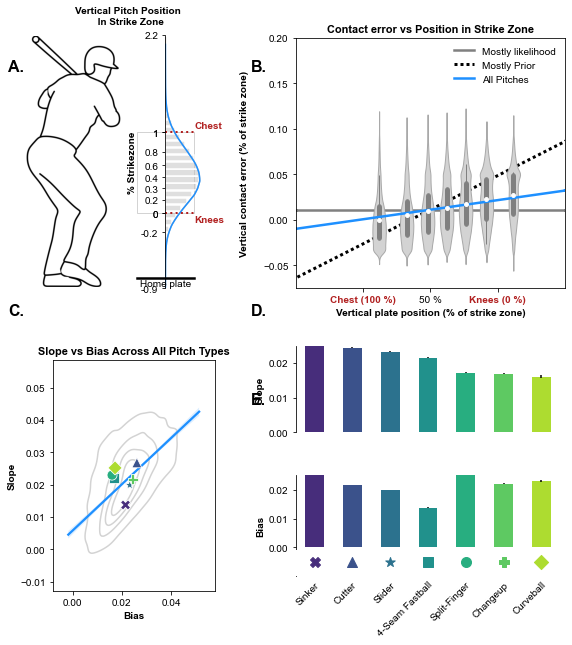

In [47]:
########################################################################
#                                                                      #
#                          MAKE FIGURE AA - V2                         #
#                                                                      #
########################################################################

# Define colors
regression_color = "dodgerblue"

cmap =  "viridis"#"plasma"#"crest"#"colorblind"
these_colors = []
for row in sns.color_palette(cmap,as_cmap=False,n_colors=len(which_pitches)): #frequent_pitches.index)):
    these_colors.append([*row,1.])
    
markers = ["X","^","*","s","o","P","D"]#,"v"]

# Get bin tick values based on .qbin()
bin_ticks = []
for ii in range(len(which_bins)):
    bin_ticks.append(np.mean(which_bins[ii:(ii+1)]))
bin_ticks_labels = list(map(str, [round(val,1) for val in bin_ticks]))
bin_ticks.extend([0,1])
bin_ticks_labels.extend(['0','1'])

# Define figures using gridspec
fig = plt.figure(constrained_layout=False)
fig.set_size_inches(7.5,8)

###########################################
#                                         #
#   Define figure layout using gridspec   #
#                                         #
###########################################

# Add first gridspec for left and middle axes
gs1 = fig.add_gridspec(nrows=1, ncols=2, left=-0.001, right=0.325, wspace=.55,width_ratios=[1,.35],top=.99,bottom=0.55)
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])

# Add second gridspec for right axis
gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.5, right=0.999,top=0.985,bottom=0.55)#
ax3 = fig.add_subplot(gs2[0,0]) 

# gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.58, right=0.985,bottom=0.8)
# ax4 = fig.add_subplot(gs3[0,0])

gs4 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.35,bottom=0.025,top=0.425)
ax5 = fig.add_subplot(gs4[0,0])

gs5 = fig.add_gridspec(nrows=1, ncols=1, left=0.5, right=0.99,bottom=0.3,top=0.45)
ax6 = fig.add_subplot(gs5[0,0])

gs6 = fig.add_gridspec(nrows=1, ncols=1, left=0.5, right=0.99,bottom=0.05,top=0.225)
ax7 = fig.add_subplot(gs6[0,0])

##############################
#                            #       
#        Axis 1 [0]          #
#                            #
##############################

# Show batter image
img = mpimg.imread('images/batter.png')
ax1.imshow(img)
ax1.axis('off') 
sns.despine()
ax1.set_xlim(120,1100)
ax1.set_ylim(2500,90)

##############################
#                            #       
#        Axis 2 [1]          #
#                            #
##############################
plot_kde_only = False

if plot_kde_only:
    sns.kdeplot(data=data, y="plate_z_norm",ax=ax2,fill=False,color="k")
    xpos, ypos_chest, ypos_knees = .75, .9875, -.02
else:
    sns.histplot(data,y="plate_z_norm",bins=35,ax=ax2,color='silver',stat='density',kde=True,shrink=0.9,edgecolor="w", linewidth=1.5,zorder=2)
    sns.kdeplot(data=data[data.pitch_name.isin(which_pitches)], y="plate_z_norm",ax=ax2,fill=False,color="dodgerblue",zorder=2)#color="darkgrey")
    xpos, ypos_chest, ypos_knees = 1, 1.05, -.1

# Add lines to label strikezone
ax2.axhline(y = 1, xmin=-.01, xmax=0.85,color='firebrick',linestyle=':',clip_on=False,zorder=2,lw=2)
ax2.axhline(y = 0, xmin=-.01, xmax=0.85,color='firebrick',linestyle=':',clip_on=False,zorder=2,lw=2)
txt1 = ax2.text(xpos,ypos_chest,"Chest",color='firebrick',fontweight="bold",zorder=2)
txt2 = ax2.text(xpos,ypos_knees,"Knees",color='firebrick',fontweight="bold",zorder=2)

# Make figure adjustments
ax2.set_xlim(0,1.25)
ax2.set_ylim(-.75,1.6)
ax2.set_yticks(ticks=bin_ticks)
ax2.set_yticklabels(bin_ticks_labels)#['1','2','3','4','5','6','7','8'])
ax2.tick_params(axis='y')#,direction='out')
ax2.set_ylabel(None)
ax2.xaxis.set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_ylabel("% Strikezone",fontweight='bold')
ax2.set_title("Vertical Pitch Position \n In Strike Zone", fontsize=10, fontweight='bold',y=1.02,x=-1)

##############################
#                            #       
#        Axis 3 [2]          #
#                            #
##############################

plt.sca(ax3)
xvals = np.unique(xx_all)
yvals = results_by_pitch[results_by_pitch.pitch.isin(["All"])].const.values[0] + (results_by_pitch[results_by_pitch.pitch.isin(["All"])].means.values[0] * xvals)
extended_xvals = np.array([-.5,*xvals,1.5])
extended_yvals = results_by_pitch[results_by_pitch.pitch.isin(["All"])].const.values[0] + (results_by_pitch[results_by_pitch.pitch.isin(["All"])].means.values[0] * extended_xvals)

# Draw lines showing slope=0 and slope~=1
likelihood_line = ax3.plot(extended_xvals,len(extended_xvals)*[results_by_pitch.loc[results_by_pitch.pitch=="All","error_at_mid"].iloc[0]],color="grey",linewidth=2.5,zorder=1,label="Mostly likelihood")
prior_bias = results_by_pitch.loc[results_by_pitch.pitch=="All","error_at_mid"].iloc[0] - (-0.075*0.5)
prior_line = ax3.plot(extended_xvals,(extended_xvals*-0.075 + prior_bias),linestyle=(0,(1,1)),color="black",linewidth=3,zorder=1,label="Mostly Prior")

# Make violin
my_violinplot(local_data=data,
              true_shift=which_data_true_shift,
              deviation=which_data_deviation,
              ax=ax3,
              which_pitches=which_pitches,
              bin_locs=which_bins_mean)

# Plot regression line #np.array((0, 158, 115))/256) # blue: 0,114,178 ; green = 0, 158, 115 ; pink = 204,121,167
reg = ax3.plot(extended_xvals,extended_yvals,lw=2.5,color=regression_color,label="All Pitches")#,zorder=3)

# Add labels
ax3.set_xlim([-.5,1.5])
plt.gca().invert_xaxis()
ax3.set_xticks([0,0.5,1])
ax3.set_ylim([-.075,0.2])
ax3.set_xticklabels(["Knees (0 %)", "50 %", "Chest (100 %)"])
ax3.get_xticklabels()[0].set_color("firebrick")
ax3.get_xticklabels()[2].set_color("firebrick")
ax3.get_xticklabels()[0].set_weight("bold")
ax3.get_xticklabels()[2].set_weight("bold")
ax3.set_xlabel("Vertical plate position (% of strike zone)",fontweight='bold')
ax3.set_ylabel("Vertical contact error (% of strike zone)",fontweight='bold',y=-.05)
ax3.set_title("Contact error vs Position in Strike Zone", fontsize=11, fontweight='bold')#,y=1.05)
ax3.yaxis.set_label_coords(-.175,.5)
ax3.spines['top'].set_visible(True)
ax3.spines['right'].set_visible(True)
ax3.legend(frameon=False)

##############################
#                            #       
#          Axis 4            #
#                            #
##############################

# Define colors and markers
regression_color = "dodgerblue"

cmap =  "viridis"#"plasma"#"crest"#"colorblind"
these_colors = []
for row in sns.color_palette(cmap,as_cmap=False,n_colors=len(which_pitches)): #frequent_pitches.index)):
    these_colors.append([*row,1.])
    
markers = ["X","^","*","s","o","P","D"]#,"v"]
    
# Make bottom left panel 
plt.sca(ax5)    
sns.kdeplot(data=data_by_pitcher_trim,x="ols_slope_abs",y="ols_const",color="lightgrey",ax=ax5,fill=False,levels=5)
sns.regplot(data=data_by_pitcher_trim,x="ols_slope_abs",y="ols_const",color="dodgerblue",ax=ax5,scatter=False)
scat = sns.scatterplot(data=results_by_pitch[results_by_pitch.pitch.isin(which_pitches)],x="absmeans",y="const",hue="pitch",style="pitch",s=100,ax=ax5,palette=cmap,hue_order=which_pitches,legend=False,markers=markers,zorder=3)#palette="crest")
ax5.spines['top'].set_visible(True)
ax5.spines['right'].set_visible(True)
ax5.set_xlabel("Bias",fontweight='bold')
ax5.set_ylabel("Slope",fontweight='bold')
ax5.set_title("Slope vs Bias Across All Pitch Types", fontsize=11, fontweight='bold')#,y=1.05)

# sort_order = data_by_pitcher_trim.groupby(by="pitch_name")["ols_slope_abs"].agg(['mean']).sort_values(by='mean',ascending=False).index.tolist()
sort_order = results_by_pitch[results_by_pitch.pitch.isin(which_pitches)].sort_values("absmeans",ascending=False).pitch.tolist()

plt.sca(ax6) 
results_by_pitch[results_by_pitch.pitch.isin(which_pitches)].sort_values("absmeans",ascending=False).plot(y="absmeans", x="pitch", kind="bar",color=these_colors, yerr=np.array(results_by_pitch[results_by_pitch.pitch.isin(which_pitches)].se_mean.tolist()).T,legend=None,ax=ax6)
ax6.spines['right'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax6.xaxis.set_visible(False)
ax6.set_xlabel(None)
ax6.set_ylabel("Slope",fontweight="bold")
ax6.set_yticks([0.0, 0.01, 0.02])
ax6.set_ylim(0,0.025)

# Run stats
fvalue, pvalue = stats.f_oneway(data_by_pitcher[data_by_pitcher.pitch_name.isin(['4-Seam Fastball'])].ols_slope_abs,
                                      data_by_pitcher[data_by_pitcher.pitch_name.isin(['Slider'])].ols_slope_abs,
                                      data_by_pitcher[data_by_pitcher.pitch_name.isin(['Sinker'])].ols_slope_abs,
                                      data_by_pitcher[data_by_pitcher.pitch_name.isin(['Changeup'])].ols_slope_abs,
                                      data_by_pitcher[data_by_pitcher.pitch_name.isin(['2-Seam Fastball'])].ols_slope_abs,
                                      data_by_pitcher[data_by_pitcher.pitch_name.isin(['Curveball'])].ols_slope_abs,
                                      data_by_pitcher[data_by_pitcher.pitch_name.isin(['Cutter'])].ols_slope_abs,
                                      data_by_pitcher[data_by_pitcher.pitch_name.isin(['Split-Finger'])].ols_slope_abs)
print(pvalue)                                                                                                          

# Plot slope and bias bar plots
plt.sca(ax7)
results_by_pitch[results_by_pitch.pitch.isin(which_pitches)].sort_values("absmeans",ascending=False).plot(y="const", x="pitch", kind="bar", color=these_colors, yerr=np.array(results_by_pitch[results_by_pitch.pitch.isin(which_pitches)].se_mean.tolist()).T,legend=None,ax=ax7)
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.spines['bottom'].set_visible(False)
ax7.set_yticks([0.0, 0.01, 0.02])
plt.setp(ax7.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax7.set_xlabel(None)
ax7.set_ylabel("Bias",fontweight="bold")
for cnt,marker in enumerate(markers):
    ax7.scatter(x=cnt,y=-0.005,s=100,marker=marker,color=these_colors[cnt])
ax7.tick_params(axis="x",length=0)
ax7.set_ylim(-.01,0.025)

# Add patch to cover bottom 
from matplotlib.patches import Rectangle
ax7.add_patch(Rectangle((-0.55,-0.001),width=0.25,height=-0.04, zorder=3,facecolor="white"))

# Add labels
ax2.text(-5.5,1.75,"A.",fontweight="bold",fontsize=16)
ax2.text(3.,1.75,"B.",fontweight="bold",fontsize=16)
ax2.text(-5.5,-1.25,"C.",fontweight="bold",fontsize=16)
ax2.text(3.,-1.25,"D.",fontweight="bold",fontsize=16)
ax2.text(3.,-2.35,"E.",fontweight="bold",fontsize=16)
ax2.plot((-1,1),(-0.8,-0.8),'k-',linewidth=2.5,clip_on=False)
ax2.text(0,-.9,"Home plate",fontsize=10,ha="center")
ax2.add_patch(Rectangle((-1,0),width=2,height=1, zorder=1,fill=False,facecolor=None,edgecolor="lightgrey",clip_on=False))

# Save figure
plt.show()
fig.savefig(os.path.join(os.getcwd(),"figures","Figure2-moneyplot_withSlopeandBias.png"), dpi=300, facecolor='w', edgecolor='w', bbox_inches="tight")


/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


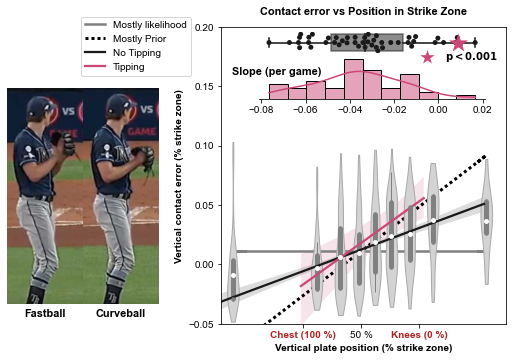

T-value =  -11.671811688617145 ; T-critical =  2.0128955952945886 ; P-val =  2.3849347033305288e-15


In [49]:
########################################################################
#                                                                      #
#                MAKE FIGURE - TYLER GLASNOW PITCH TIPPING             #   
#                                                                      #
########################################################################

# Get data for Tyler Glasnow
tg_all  = data[data.game_year.isin([2018, 2019, 2020]) & data.player_name.isin(["Glasnow, Tyler"])]
tg_alds = data[data.game_date.isin(["2019-10-10"]) & data.player_name.isin(["Glasnow, Tyler"])]

###########################################
#                                         #
#   Define figure layout using gridspec   #
#                                         #
###########################################

# Define figure
fig = plt.figure(figsize=(7,5))

# Add first gridspec for left and middle axes
gs0 = fig.add_gridspec(nrows=1, ncols=2, left=0.001, right=0.3,bottom=.01,top=0.95, wspace=0)
ax0 = fig.add_subplot(gs0[0])
ax00 = fig.add_subplot(gs0[1])

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.425, right=0.99,top=.95, wspace=.35)
ax1 = fig.add_subplot(gs1[0])

# Add second gridspec for right axis
gs2 = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1,2], left=0.5, bottom=.75, top=.935, right=0.95,hspace=0.15)
ax2 = fig.add_subplot(gs2[0])
ax3 = fig.add_subplot(gs2[1])


###########################################
#                                         #
#      Add images for each pitch type     #
#                                         #
###########################################
# Add images
plt.sca(ax0)
img = mpimg.imread('images/tyler-glasnow-pitchtipping-Fastball.jpg')
ax0.imshow(img)
ax0.axis('off') 
sns.despine()
ax0.set_title("Fastball", fontsize=11, fontweight='bold',y=-0.085)

# Add images
plt.sca(ax00)
img = mpimg.imread('images/tyler-glasnow-pitchtipping-Curveball.jpg')
ax00.imshow(img)
ax00.axis('off') 
sns.despine()
ax00.set_title("Curveball", fontsize=11, fontweight='bold',y=-0.085)

# Make violin plot
plt.sca(ax1)

########################################################
#                                                      #
#    Make violinplot and add prior/likelihood lines    #
#                                                      #
########################################################

# Draw lines for prior and likelihood
likelihood_line = ax1.plot(extended_xvals,len(extended_xvals)*[results_by_pitch.loc[results_by_pitch.pitch=="All","error_at_mid"].iloc[0]],color="grey",linewidth=2.5,zorder=1,label="Mostly likelihood")
prior_bias = results_by_pitch.loc[results_by_pitch.pitch=="All","error_at_mid"].iloc[0] - (-0.075*0.5)
prior_line = ax1.plot(extended_xvals,(extended_xvals*-0.075 + prior_bias),linestyle=(0,(1,1)),color="black",linewidth=3,zorder=1,label="Mostly Prior")

# Make violinplot
my_violinplot(local_data=tg_all,
              true_shift=which_data_true_shift,
              deviation=which_data_deviation,
              ax=ax1,
              which_pitches=which_pitches,
              bin_locs=which_bins_mean)

# Compute regression  for each game
slope_vals = []
error_vals = []
game_ids   = []
for game_id in tg_all.game_pk.unique():
    try:
        tempdat = tg_all[(tg_all.game_pk.isin([game_id])) & (tg_all.pitch_name.isin(which_pitches))]
        xx = np.array(tempdat[which_data_true_shift])#_qbinned_percent_mean
        yy = np.array(tempdat[which_data_deviation])
        if (len(xx) >= 10):
            # Run regression for each game
            ols_result = run_regression(xx,yy)
            slope_vals.append(ols_result.params[1])
            error_vals.append(ols_result.params[0] + (ols_result.params[1] * (0)))
            
            # Get data from tipping game
            if (game_id == 599341):
                game_ids.append( "Tipping")
            else:
                game_ids.append("Rest of Season")
            # #     
            # xvals = np.unique(xx)
            # yvals = ols_result.params[0] + ols_result.params[1] * xvals

    except:
        print(len(xx),len(yy))

# Add data to dataframe
scatter_data = pd.DataFrame({"slope": slope_vals,"abs_slope": [abs(ii) for ii in slope_vals], "error": error_vals,"game_ids": game_ids})

# Regression line params
cmap_local = cm.get_cmap("plasma")
local_color = (0.1,0.1,0.1) #order.color[3]
regression_color = cmap_local(0.5)#order.color[5]

# Perform regression for all pitches vs alds tipping game
sns.regplot(data=tg_all,x=which_data_true_shift,y=which_data_deviation,scatter=False,ci=95,color=local_color,label="No Tipping")
sns.regplot(data=tg_alds,x=which_data_true_shift,y=which_data_deviation,scatter=False,ci=95,color=regression_color,label="Tipping")#,color="pink")

# Add labels
plt.gca().invert_xaxis()
ax1.set_xticks([0,0.5,1])
ax1.set_xticklabels(["Knees (0 %)", "50 %", "Chest (100 %)"])
ax1.get_xticklabels()[0].set_color("firebrick")
ax1.get_xticklabels()[2].set_color("firebrick")
ax1.get_xticklabels()[0].set_weight("bold")
ax1.get_xticklabels()[2].set_weight("bold")
ax1.set_xlabel("Vertical plate position (% strike zone)",fontweight='bold')
ax1.set_ylabel("Vertical contact error (% strike zone)",fontweight='bold')
ax1.set_title("Contact error vs Position in Strike Zone", fontsize=11, fontweight='bold',y=1.02)
ax1.set_ylim(-.05, .2)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.legend(loc="upper left",frameon=True, bbox_to_anchor=(-.51,1.05))
    

###########################################
#                                         #
#  Make boxplot/swarmplot and histogram   #
#                                         #
###########################################

plt.sca(ax2)
sns.boxplot(x="abs_slope", data=scatter_data[scatter_data.game_ids=="Rest of Season"],color=local_color,boxprops=dict(alpha=.5))
sns.swarmplot(x="abs_slope", data=scatter_data[scatter_data.game_ids=="Rest of Season"],color=local_color)
sns.swarmplot(x="abs_slope", data=scatter_data[scatter_data.game_ids=="Tipping"],color=regression_color,s=20,marker="*",label="$\\bf{p < 0.001}$")
ax2leg = ax2.legend(loc="lower center",frameon=False,prop={"size":10}, markerscale=.75,bbox_to_anchor=(0.875,-.95))
ax2.axis('off')
ax2.set_zorder(3)

plt.sca(ax3)
sns.histplot(x="slope", data=scatter_data[scatter_data.game_ids=="Rest of Season"],bins=11,color=regression_color,kde=True)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.yaxis.set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_title("Slope (per game)", fontsize=11, fontweight='bold',y=.45, x = 0.08)
plt.yticks(fontsize=9, rotation=70)

plt.show()

# Compute statistics on tipping vs no tipping
meanval, stdval = scatter_data[scatter_data.game_ids=="Rest of Season"].slope.describe()[['mean','std']]
n_samples = len(scatter_data.game_ids)-1
std_error = stdval/np.sqrt(n_samples)
t_value = (scatter_data[scatter_data.game_ids=="Tipping"].slope.to_numpy()[0] - meanval)/std_error
dof = len(scatter_data.game_ids)-2
t_critical = stats.t.ppf(q=.975,df=dof)

pval = stats.t.sf(np.abs(t_value), dof)*2 

print("T-value = ", t_value , "; T-critical = ", t_critical, "; P-val = ", pval)

fig.savefig(os.path.join(os.getcwd(),"figures","Figure4-pitchtipping.png"), dpi=300, facecolor='w', edgecolor='w', bbox_inches="tight")

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_46502/2257236314.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["Knees (0 %)", "50 %", "Chest (100 %)"])


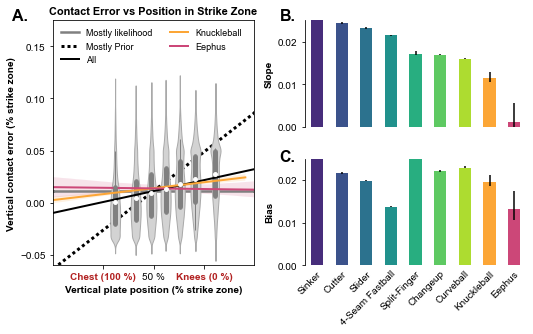

In [50]:
########################################################################
#                                                                      #
#      MAKE FIGURE - SIDE BY SIDE KNUCKLEBALL AND EEPHUS               #   
#                                                                      #
########################################################################

# Define figure
fig = plt.figure(figsize=(7,4))

# Add first gridspec for violinplot
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.45, bottom=0.05,top=0.9)
ax1 = fig.add_subplot(gs1[0])

# Add gridspec for slope bar plot
gs2 = fig.add_gridspec(nrows=2, ncols=1, left=0.55, right=0.99,bottom=.05,top=.9,hspace=.3)
ax2 = fig.add_subplot(gs2[0])
ax3 = fig.add_subplot(gs2[1])

# gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.95, bottom=0.35,top=0.95)
# ax1 = fig.add_subplot(gs1[0])

#### Define colors ####
cmap_all = "viridis"
# all_clr = cmap_all(0.5)
cmap = cm.get_cmap('plasma')
# define_colors = [cmap(0.8), cmap(0.6),cmap(0.4), cmap(0.2)]
# define_colors = [colors.to_rgba("firebrick"), colors.to_rgba("mediumseagreen")]#[cmap(0.8), cmap(0.5)]#, cmap(0.2)]
define_colors = [cmap(0.8), cmap(0.5)]#, cmap(0.2)]

these_colors = []
for row in sns.color_palette(cmap_all,as_cmap=False,n_colors=len(which_pitches)): #frequent_pitches.index)):
    these_colors.append([*row,1.])
markers = ["X","^","*","s","o","P","D"]

##################################################
#                                                #   
#        Make violin plot for Knuckleball        #
#                                                #
##################################################

plt.sca(ax1)

likelihood_line = ax1.plot(extended_xvals,len(extended_xvals)*[results_by_pitch.loc[results_by_pitch.pitch=="All","error_at_mid"].iloc[0]],color="grey",linewidth=2.5,zorder=1,label="Mostly likelihood")
prior_bias = results_by_pitch.loc[results_by_pitch.pitch=="All","error_at_mid"].iloc[0] - (-0.075*0.5)
prior_line = ax1.plot(extended_xvals,(extended_xvals*-0.075 + prior_bias),linestyle=(0,(1,1)),color="black",linewidth=3,zorder=1,label="Mostly Prior")

my_violinplot(local_data=data,
              true_shift=which_data_true_shift,
              deviation=which_data_deviation,
              ax=ax1,
              which_pitches=which_pitches,
              bin_locs=which_bins_mean)

# Get data for plotting
xvals = np.unique(xx_all)
yvals = results_by_pitch[results_by_pitch.pitch.isin(["All"])].const.values[0] + (results_by_pitch[results_by_pitch.pitch.isin(["All"])].means.values[0] * xvals)

# Plot regression line
regression_color = 'black'#'dodgerblue' #np.array((0, 158, 115))/256) # blue: 0,114,178 ; green = 0, 158, 115 ; pink = 204,121,167
reg = ax1.plot(xvals,yvals,lw=2,color=regression_color,label="All")


knuckleballs = data[data.pitch_name.isin(['Knuckleball'])]
sns.regplot(data=knuckleballs,x=which_data_true_shift,y=which_data_deviation,scatter=False,ci=95,label="Knuckleball",line_kws=dict(lw=2),color=define_colors[0])
        
eephus = data[data.pitch_name.isin(['Eephus'])]#data[data.release_speed < 60] #
sns.regplot(data=eephus,x=which_data_true_shift,y=which_data_deviation,scatter=False,ci=95,label="Eephus",line_kws=dict(lw=2),color=define_colors[1])        
    
xx = np.array(knuckleballs[which_data_true_shift])#_qbinned_percent_mean
yy = np.array(knuckleballs[which_data_deviation])
X = sm.add_constant(xx)#, prepend=False)
ols = sm.OLS(yy,X)
ols_result = ols.fit()
slope_vals.append(ols_result.params[1])
error_vals.append(ols_result.params[0] + (ols_result.params[1] * (0.4)))
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(ols_result) # for getting confidence intervals
xvals = np.unique(xx)
yvals = ols_result.params[0] + ols_result.params[1] * xvals

            
knuckleball_df = pd.DataFrame({'pitch': ['Knuckleball'],'pitch_code': ['KN'],
                               'const': [ols_result.params[0]],
                               'means': [ols_result.params[1]], 
                               'absmeans': [abs(ols_result.params[1])], 
                               'se_mean': [[ols_result.bse[0], ols_result.bse[1]]],
                               'se_mean_lo': [ols_result.params[1] - ols_result.bse[0]],
                               'se_mean_hi': [ols_result.params[1] + ols_result.bse[1]],
                                'error_at_mid': [ols_result.params[0] + ols_result.params[1] * (0)]})

knuckleball_results = results_by_pitch.sort_values("absmeans",ascending=False).append(knuckleball_df)
    

xx = np.array(eephus[which_data_true_shift])#_qbinned_percent_mean
yy = np.array(eephus[which_data_deviation])
X = sm.add_constant(xx)#, prepend=False)
ols = sm.OLS(yy,X)
ols_result = ols.fit()
slope_vals.append(ols_result.params[1])
error_vals.append(ols_result.params[0] + (ols_result.params[1] * (0.4)))
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(ols_result) # for getting confidence intervals
xvals = np.unique(xx)
yvals = ols_result.params[0] + ols_result.params[1] * xvals

            
eephus_df = pd.DataFrame({'pitch': ['Eephus'],'pitch_code': ['EP'],
                               'const': [ols_result.params[0]],
                               'means': [ols_result.params[1]], 
                               'absmeans': [abs(ols_result.params[1])], 
                               'se_mean': [[ols_result.bse[0], ols_result.bse[1]]],
                               'se_mean_lo': [ols_result.params[1] - ols_result.bse[0]],
                               'se_mean_hi': [ols_result.params[1] + ols_result.bse[1]],
                                'error_at_mid': [ols_result.params[0] + ols_result.params[1] * (0)]})

eephus_results = knuckleball_results.append(eephus_df)
eephus_results = eephus_results[eephus_results.pitch != "All"]

# Add labels
# ax1.set_xticks([0,0.5,1])
ax1.set_xticklabels(["Knees (0 %)", "50 %", "Chest (100 %)"])
ax1.get_xticklabels()[0].set_color("firebrick")
ax1.get_xticklabels()[2].set_color("firebrick")
ax1.get_xticklabels()[0].set_weight("bold")
ax1.get_xticklabels()[2].set_weight("bold")
ax1.set_xlabel("Vertical plate position (% strike zone)",fontweight='bold')
ax1.set_ylabel("Vertical contact error (% strike zone)",fontweight='bold')
ax1.set_title("Contact Error vs Position in Strike Zone", fontsize=11, fontweight='bold')
ax1.set_ylim(-.06, .175)
ax1.set_xlim(extended_xvals[0],extended_xvals[-1:])
ax1.set_xticks([0,0.5,1])
ax1.invert_xaxis()
ax1.legend(loc="upper left",frameon=False,fontsize=9,ncol=2) #, bbox_to_anchor=(-.4,1.5)
ax1.spines['top'].set_visible(True)    
ax1.spines['right'].set_visible(True)    

plt.sca(ax2)
eephus_results.plot(y="absmeans", x="pitch", kind="bar", yerr=np.array(eephus_results.se_mean.tolist()).T,legend=None,ax=ax2,color=list(these_colors + define_colors))#7*[(0.5,0.5,0.5,1)])# define_colors[:-1] + define_colors[:2] + [define_colors[-1]],)#plt.cm.Paired(np.arange(len(frequent_pitches.index))))#,colormap=these_colors)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.xaxis.set_visible(False)
ax2.set_xlabel(None)
ax2.set_ylabel("Slope",fontweight="bold")
ax2.set_yticks([0.0, 0.01, 0.02])
ax2.set_ylim(0,0.025)
# ax2.set_ylabel(None)#"Slope of Error",fontsize=12,fontweight="bold")
# ax2.set_xlabel(None)
# ax2.tick_params(labelbottom=True)
# ax2.set_title("Slope by Pitch",fontsize=11,fontweight="bold")#,loc='left')
# ax2.spines['top'].set_visible(True)
# ax2.spines['right'].set_visible(True)
# ax2.set_ylim([0,0.03])
# ax2.set_yticks(ticks=np.linspace(0,0.03,4))  
# ax2.yaxis.set_minor_locator(ticker.FixedLocator(np.linspace(0,0.03,16)))#AutoMinorLocator())
# ax2.grid(b=True, which='both', color="lightgray", linewidth=.35)
# plt.xticks(rotation=0)

plt.sca(ax3)
eephus_results.plot(y="const", x="pitch", kind="bar", yerr=np.array(eephus_results.se_mean.tolist()).T,legend=None,ax=ax3,color=list(these_colors + define_colors))#7*[(0.5,0.5,0.5,1)])# define_colors[:-1] + define_colors[:2] + [define_colors[-1]],)#plt.cm.Paired(np.arange(len(frequent_pitches.index))))#,colormap=these_colors)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
#ax7.xaxis.set_visible(False)
ax3.set_yticks([0.0, 0.01, 0.02])
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax3.set_xlabel(None)
ax3.set_ylabel("Bias",fontweight="bold")
# for cnt,marker in enumerate(markers):
#     ax3.scatter(x=cnt,y=-0.005,s=100,marker=marker,color=these_colors[cnt])
ax3.tick_params(axis="x",length=0)
# ax3.set_ylim(-.01,0.025)
ax3.set_ylim(0,0.025)

ax1.text(1.90,.175,"A.",fontweight="bold",fontsize=16)
ax1.text(-.75,.175,"B.",fontweight="bold",fontsize=16)
ax1.text(-.75,0.04,"C.",fontweight="bold",fontsize=16)


# ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# # ax3.set_yticks(ax3.get_yticks()[:-1])
# ylabels = [item.get_text() for item in ax2.get_yticklabels()]
# ylabels[0] = "poop"
# ax2.set_yticklabels(ylabels)

# ax2.set_yticklabels(ax2.get_yticklabels()[-1:][0].set_text("poop"))

# ax3.set_ylabel(None)#"Slope of Error",fontsize=12,fontweight="bold")
# ax3.set_xlabel(None)
# ax3.tick_params(labelbottom=True)
# ax3.set_title("Slope by Pitch",fontsize=11,fontweight="bold")#,loc='left')
# ax3.spines['top'].set_visible(True)
# ax3.spines['right'].set_visible(True)
# ax3.set_ylim([0,0.03])
# ax3.set_yticks(ticks=np.linspace(0,0.03,4))  
# ax3.yaxis.set_minor_locator(ticker.FixedLocator(np.linspace(0,0.03,16)))#AutoMinorLocator())
# ax3.grid(b=True, which='both', color="lightgray", linewidth=.35)
# plt.xticks(rotation=0)

# plt.tight_layout()
fig.savefig(os.path.join(os.getcwd(),"figures","Figure3-KnuckleballAndEephus.png"), dpi=300, facecolor='w', edgecolor='w',bbox_inches="tight")
